# Can We Agree on Science

### Preparation

In [1]:
import cPickle as pickle
import random
import numpy as np
from igraph import *
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import locclass
from matplotlib.ticker import MaxNLocator
from progressbar import ProgressBar

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from bokeh.plotting import ColumnDataSource, figure, output_notebook, output_file, show
from bokeh.models import HoverTool
output_notebook()
TOOLS = 'wheel_zoom,box_zoom,pan,reset,save,hover'

Loading BokehJS ...

In [3]:
classification=pickle.load(open('../BookCodes/classifications_new.pkl'))
print "Classifications loaded. E.g., classification['0887381324']={}".format(classification['0887381324'])
print "How many ISBNs' have Dewey codes: {}".format(Counter([len(classification[x]['dewey'])>0 for x in classification]))
print "How many ISBNs' have LoC codes: {}".format(Counter([len(classification[x]['loc'])>0 for x in classification]))
T_loc=pickle.load(open('../Classifications/loc_tree.pkl'))
T_dd=pickle.load(open('../Classifications/dd_tree.pkl'))
g = pickle.load(open('../AmazonBooks/asin_network.pkl','rb'))
print "Co-purchase network loaded: {}".format(g.summary())
asin2id = pickle.load(open('../AmazonBooks/asin2id.pkl','r'))
isbn2asin = pickle.load(open('../AmazonBooks/isbn_lookup.pkl'))
asin2isbn=pickle.load(open("../AmazonBooks/asin_lookup.pkl"))

Classifications loaded. E.g., classification['0887381324']={'loc': 'HD9574.E22', 'dewey': '338.2728209866'}
How many ISBNs' have Dewey codes: Counter({True: 1234621, False: 51470})
How many ISBNs' have LoC codes: Counter({True: 1219499, False: 66592})
Co-purchase network loaded: IGRAPH UN-- 1303504 26467385 -- 
+ attr: name (v), title (v)


#### Populate books into Dewey and LoC classification trees

In [4]:
for t in T_loc.vs:
    t['books']=set()
for t in T_dd.vs:
    t['books']=set()

pbar = ProgressBar()
for isbn in pbar(classification):
    if classification[isbn]['dewey']:
        j=classification[isbn]['dewey']
        code=j.split('.')[0]
        if not code.isdigit():
            continue
        if len(code)>3:
            continue
        t=T_dd.vs.find(code)
        t['books'].add(asin2id[isbn2asin[isbn]])
    if classification[isbn]['loc']:
        code = classification[isbn]['loc']
        if code:
            topic=locclass.locclass(code)
            t=T_loc.vs.find(topic)
            t['books'].add(asin2id[isbn2asin[isbn]])

100% |########################################################################|


In [5]:
def traverse(T,node,depth):
    T.vs[node]['depth']=depth
    for u in T.neighbors(node,OUT):
        traverse(T,u,depth+1)
        T.vs[node]['books']|= T.vs[u]['books']
    T.vs[node]['size']=len(T.vs[node]['books'])

In [6]:
traverse(T_dd,0,0)
traverse(T_loc,0,0)

#### Build our classification trees

In [7]:
def buildTree(filename='disciplines.txt',source='combine',rootname='Root'):
    infile=open(filename)
    for i,l in enumerate(infile): # in case excel does not use \n to end lines
        if i>0:
            break
    infile.close()
    if i==0:  
        infile=l.split('\r')
    else:
        infile=open(filename)
    field=None
    discipline=None
    T=Graph(directed=True)
    T.add_vertex(name=rootname,label=rootname,depth=0)
    T.vs.find(rootname)['books']=set()
    for l in infile:
        items=l.split('\t')
        if items[0] and (not items[1]) and (not items[2]) and (not items[3]):
            T.add_vertex(name=items[0],label=items[0],depth=1)
            field=T.vs.find(items[0])
            T.add_edge(rootname,field)
            field['books']=set()
        elif items[0] and (not items[1]) and items[2] and (not items[3]):
            T.add_vertex(name=field['name']+'/'+items[0],label=items[0],depth=2)
            discipline=T.vs.find(field['name']+'/'+items[0])
            T.add_edge(field,discipline)
            discipline['books']=set()
        elif items[0] or items[2]:
            if items[0] and (source=='dd' or source=='combine'):
                T.add_vertex(name=items[0],label=items[1],depth=3)
                t=T.vs.find(items[0])
                t['books']=T_dd.vs.find(items[0])['books']
                T.add_edge(discipline,t)
            if items[2] and (source=='loc' or source=='combine'):
                T.add_vertex(name=items[2],label=items[3],depth=3)
                t=T.vs.find(items[2])
                t['books']=T_loc.vs.find(items[2])['books']
                T.add_edge(discipline,t)
    return T

* Science tree

In [8]:
infile='../Disciplines/disciplines(01-20).txt'
D_loc=buildTree(filename=infile,source='loc',rootname='Sciences')
D_dd=buildTree(filename=infile,source='dd',rootname='Sciences')
D_com=buildTree(filename=infile,source='combine',rootname='Sciences')

* Nonscience tree

In [9]:
infile='../Disciplines/nonsciences.txt'
N_loc=buildTree(filename=infile,source='loc',rootname='Nonsciences')
N_dd=buildTree(filename=infile,source='dd',rootname='Nonsciences')
N_com=buildTree(filename=infile,source='combine',rootname='Nonsciences')

#### Visulaize the tree

In [ ]:
plot(D_loc.vs(depth_le=2).subgraph(),
     layout=D_loc.vs(depth_le=2).subgraph().layout_reingold_tilford_circular(root=0),
     vertex_label=D_loc.vs(depth_le=2)['label'],vertex_size=30)

In [ ]:
plot(N_loc.vs(depth_le=2).subgraph(),
     layout=N_loc.vs(depth_le=2).subgraph().layout_reingold_tilford_circular(root=0),
     vertex_label=N_loc.vs(depth_le=2)['label'],vertex_size=20)

#### Populate books into the trees

In [10]:
traverse(D_dd,0,0)
traverse(D_loc,0,0)
traverse(D_com,0,0)

In [11]:
traverse(N_dd,0,0)
traverse(N_loc,0,0)
traverse(N_com,0,0)

#### Build intersection tree

In [12]:
D_int=D_com.vs(depth_le=2).subgraph()
for v in D_int.vs:
    v['books']=D_loc.vs.find(v['name'])['books'] & D_dd.vs.find(v['name'])['books']
    v['size']=len(v['books'])

In [13]:
N_int=N_com.vs(depth_le=2).subgraph()
for v in N_int.vs:
    v['books']=N_loc.vs.find(v['name'])['books'] & N_dd.vs.find(v['name'])['books']
    v['size']=len(v['books'])

#### Number of books

In [14]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":[D_com.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Intersect":[D_int.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['size'] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"]).append(
    pd.DataFrame({"Discipline":N_int.vs['name'],
                 "Combined":[N_com.vs.find(i['name'])['size'] for i in N_int.vs],
                 "Intersect":[N_int.vs.find(i['name'])['size'] for i in N_int.vs],
                 "Dewey":[N_dd.vs.find(i['name'])['size'] for i in N_int.vs],
                 "LoC":[N_loc.vs.find(i['name'])['size'] for i in N_int.vs],
                 "Level":N_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"]))
print df[df.Level<=1].to_string(index=False)

Discipline   Dewey     LoC  Combined  Intersect  Level
         Sciences  347513  359974    428433     279054      0
Physical sciences   78482   75628     91794      62316      1
    Life sciences   75091   79905     90875      64121      1
  Social sciences  101600   91697    134258      59039      1
       Humanities   92452  112818    128292      76978      1
      Nonsciences  435688  368628    494278     310038      0
             Arts  103514   52604    113581      42537      1
           Sports   47405   17052     49878      14579      1
       Literature  192065  255109    269487     177687      1
         Religion   92854   43903     97271      39486      1


###  Book Level

#### Calculate alignment of books

In [15]:
liberals=set()
with open('../BookCodes/liberals1008.txt') as l:
    for line in l:
        liberals.add(asin2id[isbn2asin[line.strip()]])

conservatives=set()
with open('../BookCodes/conservatives1008.txt') as c:
    for line in c:
        conservatives.add(asin2id[isbn2asin[line.strip()]])

for u in g.vs:
    u['color']=[0,0,0]

for u in liberals:
    g.vs[u]['color'][2]=1

for u in conservatives:       
    g.vs[u]['color'][0]=1

In [16]:
for u in g.vs:
    kr=0
    kb=0
    for v in u.neighbors():
        if v['color'][2]==1:
            kb+=1
        if v['color'][0]==1:
            kr+=1
    u['kb']=kb
    u['kr']=kr

d=g.vs(color=[0,0,0])
d=np.add(d['kr'],d['kb'])
Ed=d[d>0].mean()
kr=sum(g.vs(color=[1,0,0]).degree())
kb=sum(g.vs(color=[0,0,1]).degree())
fred=1.0*kr/(kr+kb)
fblue=1.0*kb/(kr+kb)
pbar=ProgressBar()
for u in pbar(g.vs):
    if u['color']==[0,0,0]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k==0:
            continue
        a=Ed*fblue+kb
        b=Ed*fred+kr
        r=b/(a+b)
        if r<=fred:
            r=r/fred*0.5
        else:
            r=(r-fred)/fblue*0.5+0.5
        u['color'][0]=r
        u['color'][2]=1-r

100% |########################################################################|


In [ ]:
books=g.vs(list(D_com.vs[0]['books']))
df=pd.DataFrame({'name': books['name'], 
                 'kr': books['kr'], 
                 'kb': books['kb'],
                 'alignment': zip(*books['color'])[0]})
df['k']=df['kb']+df['kr']
df.to_csv('../AmazonBooks/scienceBooks.csv',sep='\t', index=False)

#### Add publisher data

In [17]:
isbn2publisher=pickle.load(open("../AmazonBooks/isbn2publisher.pkl"))

In [18]:
academicPublisher={}
with open("../AmazonBooks/academic_publishers.txt") as infile:
    for line in infile:
        key,v = line.split('\t')
        academicPublisher[key.strip()]=int(v.strip())

In [19]:
pbar=ProgressBar()
for u in pbar(g.vs):
    academic=0
    for isbn in asin2isbn[u['name']]:
        if isbn2publisher[isbn].lower() in academicPublisher:
            if academicPublisher[isbn2publisher[isbn].lower()]==1:
                academic=1
                break
        elif ('university' in isbn2publisher[isbn].lower()) or ('academic' in isbn2publisher[isbn].lower()):
            academic=1
            break
    u['academic']=academic

100% |########################################################################|


#### Consistency of book alignment

In [22]:
blueIndex=[]
redIndex=[]
for u in g.vs:
    if u['color']==[1,0,0]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k!=0:
            redIndex.append(u.index)
    elif u['color']==[0,0,1]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k!=0:
            blueIndex.append(u.index)

In [23]:
kRed=sum(g.vs(redIndex).degree())
kBlue=sum(g.vs(blueIndex).degree())
kRed*1.0/(kRed+kBlue),fred

(0.6760796213682375, 0.6622330542744104)

In [24]:
ideologyBooks={}
for u in g.vs(list(set(blueIndex) | set(redIndex))):
    kr=u['kr']
    kb=u['kb']
    k=kb+kr
    if k==0:
        ideologyBooks[u['name']]=0
        continue
    a=Ed*fblue+kb
    b=Ed*fred+kr
    r=b/(a+b)
    if r<=fred:
        r=r/fred*0.5
    else:
        r=(r-fred)/fblue*0.5+0.5
    ideologyBooks[u['name']]=r

df=pd.DataFrame({'ASIN':ideologyBooks.keys(),
                 'alignment':ideologyBooks.values(),
                 'ideology':map(lambda x:g.vs.find(x)['color'][0],ideologyBooks.keys()),
                 'title':map(lambda x:g.vs.find(x)['title'],ideologyBooks.keys()),
                 'k':map(lambda x:g.vs.find(x).degree(),ideologyBooks.keys())})

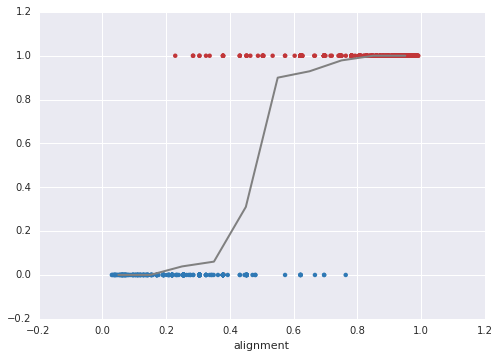

In [25]:
df2=df[df.alignment>0]
xbins=np.arange(0,1.1,0.1)
books,_=np.histogram(df2['alignment'],xbins)
redBooks,_=np.histogram(df2['alignment'],xbins,weights=df2['ideology'])
y=np.zeros_like(redBooks,dtype=float)
y[books!=0]=1.0*redBooks[books!=0]/books[books!=0]
sns.set_palette("RdBu_r")
plt.scatter(df2['alignment'],df2['ideology'],c=map(lambda x: [ 0.18431374,0.47266437,0.71164938] if x==0 else [ 0.75617072, 0.21038063,  0.22352942], df2['ideology']),edgecolors='none')
plt.plot((xbins[1:]+xbins[:-1])/2,y,lw=2,color='grey')
plt.xlabel('alignment');

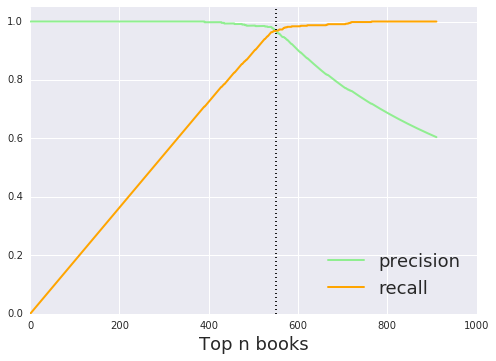

In [26]:
df3=df2[['alignment','ideology']]
total=df3['ideology'].sum()
df3=df3.sort_values('alignment',ascending=False)
precision=[]
recall=[]
x=range(1,df3.shape[0]+1)
for i in x:
    books=df3['ideology'].iloc[:i].sum()
    precision.append(1.0*books/i)
    recall.append(1.0*books/total)
    
plt.plot(x,precision,color='lightgreen',lw=2)
plt.plot(x,recall,color='orange', lw=2)
plt.plot([total,total],[0,1.05],':',color='k')
plt.ylim([0,1.05])
plt.legend(['precision','recall'],fontsize=18,loc='best')
plt.xlabel('Top n books',fontsize=18);

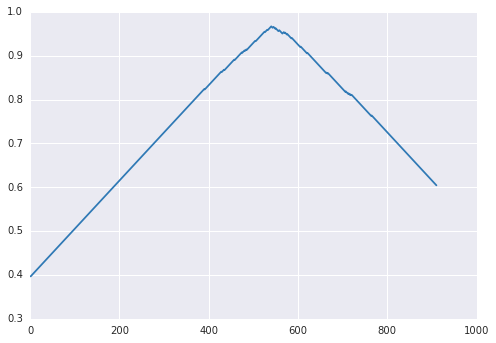

In [27]:
correlation=[]
for i in xrange(1,df3.shape[0]+1):
    imputed=np.zeros_like(df3['ideology'])
    imputed[:i]=1
    #correlation.append(stats.pearsonr(imputed,df3['ideology']))
    correlation.append((imputed==df3['ideology']).sum()*1.0/len(imputed))
plt.plot(xrange(1,df3.shape[0]+1),correlation);

In [28]:
print "Max correlation achieved at cutting at top {} books".format(np.argmax(correlation))
print "If cutting at top 539 books, correlation is {}".format(correlation[539])
print df3.iloc[539]

Max correlation achieved at cutting at top 539 books
If cutting at top 539 books, correlation is 0.967032967033
alignment    0.488034
ideology     1.000000
Name: 771, dtype: float64


### Aggregated Level

#### Calculate alignment

In [74]:
def calculateAlignment(T):
    # Leaves of the tree
    for t in T.vs:
        t['color']=[0,0,0]
        if t['books']:
            t['kr']=sum(g.vs[list(t['books'])]['kr'])
            t['kb']=sum(g.vs[list(t['books'])]['kb'])
        else:
            t['kr']=0
            t['kb']=0

    T2=T.copy()
    T2.vs['out_degree']=T2.degree(mode=OUT)
    d=T2.vs.select(out_degree=0)
    d=np.add(d['kr'],d['kb'])
    Ed=1#np.median(d)

    for leaf in T2.vs.select(out_degree=0):
        u=T.vs.find(leaf['name'])
        k=leaf['kb']+leaf['kr']
        a=Ed*fblue+leaf['kb']
        b=Ed*fred+leaf['kr']
        r=b/(a+b)
        if r<=fred:
            r=r/fred*0.5
        else:
            r=(r-fred)/fblue*0.5+0.5
        u['color']=[r,0,1-r]
        u['ci']=[]
        for r in stats.beta.interval(0.99,b,a):
            if r<=fred:
                r=r/fred*0.5
            else:
                r=(r-fred)/fblue*0.5+0.5
            u['ci'].append(r)
        if k>0:
            books=g.vs(list(leaf['books']))
            kr=np.array(books['kr'])
            kb=np.array(books['kb'])
            u['psize']=np.count_nonzero(kr+kb)
        else:
            u['psize']=0
        u['strength']=np.sum(g.vs[list(u['books'])].degree(), dtype=float) - g.vs[list(u['books']-conservatives-liberals)].subgraph().ecount()*2
        if leaf['books']:
            u['academic']=sum(g.vs(list(leaf['books']))['academic'])*1.0/u['size']
        else:
            u['academic']=0
    T2.delete_vertices(T2.vs.select(out_degree=0))

    # Internal nodes of the tree
    while T2:
        T2.vs['out_degree']=T2.degree(mode=OUT)
        d=T2.vs.select(out_degree=0)
        d=np.add(d['kr'],d['kb'])
        Ed=10#np.median(d)
        for leaf in T2.vs.select(out_degree=0):
            u=T.vs.find(leaf['name'])
            kb=u['kb']
            kr=u['kr']
            k=kb+kr
            a=Ed*fblue+kb
            b=Ed*fred+kr
            r=b/(a+b)
            if r<=fred:
                r=r/fred*0.5
            else:
                r=(r-fred)/fblue*0.5+0.5
            u['color']=[r,0,1-r]
            u['ci']=[]
            for r in stats.beta.interval(0.99,b,a):
                if r<=fred:
                    r=r/fred*0.5
                else:
                    r=(r-fred)/fblue*0.5+0.5
                u['ci'].append(r)
            if k>0:
                books=g.vs(list(leaf['books']))
                kr=np.array(books['kr'])
                kb=np.array(books['kb'])
                u['psize']=np.count_nonzero(kr+kb)
            else:
                u['psize']=0
            u['strength']=np.sum(g.vs[list(u['books'])].degree(), dtype=float) - g.vs[list(u['books']-conservatives-liberals)].subgraph().ecount()*2
            if leaf['books']:
                u['academic']=sum(g.vs(list(leaf['books']))['academic'])*1.0/u['size']
            else:
                u['academic']=0
        T2.delete_vertices(T2.vs.select(out_degree=0))

In [75]:
#calculateAlignment(D_com)
calculateAlignment(D_dd)
calculateAlignment(D_loc)

In [76]:
#calculateAlignment(N_com)
calculateAlignment(N_dd)
calculateAlignment(N_loc)

#### Calculate applied index

In [32]:
# Ciations from patents
journal=pickle.load(open('../Patent/journals.pkl'))
dd_patent=Counter()
loc_patent=Counter()
pbar=ProgressBar()
for i in pbar(journal):
    if journal[i]['npatents']:
        for d in journal[i]['dewey']:
            dd_patent[d.split('.')[0]]+=journal[i]['npatents']
        for d in journal[i]['lc']:
            t=locclass.locclass(d)
            loc_patent[t]+=journal[i]['npatents']

100% |########################################################################|


In [33]:
def calculateCites(T,kind=None):
    if kind=='dd':
        #Citation graph
        G=Graph.Read_Ncol('../Citation/edgelist_dd_class.txt', names=True, weights=True, directed=True)
        # Ciations from patents
        patents=dd_patent
    elif kind=='loc':
        G=Graph.Read_Ncol('../Citation/edgelist_loc_class.txt', names=True, weights=True, directed=True)
        patents=loc_patent
    else:
        print "Please specify 'dd' or 'loc'."
        return
    G.simplify(multiple=True, loops=True, combine_edges=sum)
    pbar=ProgressBar()
    for u in pbar(T.vs):
        try:
            u['journalCites']=G.vs.find(u['name']).degree(mode=IN)
        except:
            u['journalCites']=0
        try:
            u['patentCites']=patents[u['name']]
        except:
            u['patentCites']=0

In [34]:
calculateCites(D_dd,'dd')
calculateCites(D_loc,'loc')

100% |########################################################################|
100% |########################################################################|


#### Calculate relevance

In [23]:
def calculateRelevance(T):
    fPolitical=(sum(g.vs(color=[1,0,0]).degree())+sum(g.vs(color=[0,0,1]).degree()))*1.0/g.ecount()/2
    Ed=10.0
    for u in T.vs:
        u['relevance']=(u['kr']+u['kb']+Ed*fPolitical)/(u['strength']+Ed)

In [24]:
#calculateRelevance(D_com)
calculateRelevance(D_dd)
calculateRelevance(D_loc)

In [25]:
#calculateRelevance(N_com)
calculateRelevance(N_dd)
calculateRelevance(N_loc)

#### Calculate scientific breadth

In [29]:
# This one calculates average breadth per political book
def calculateBreadth(T):
    for u in T:
        books=np.array(list(u['books']))
        relevantBooks=books[np.array(g.vs[list(books)]['kr'])+np.array(g.vs[list(books)]['kb'])>0]
        redbooks=set()
        bluebooks=set()
        for b in relevantBooks:
            for neighbor in g.neighbors(b):
                if neighbor in conservatives:
                    redbooks.add(neighbor)
                if neighbor in liberals:
                    bluebooks.add(neighbor)
        if redbooks:
            u['redbreadth']=np.count_nonzero(g.vs[list(books)]['kr'])*1.0/len(redbooks)
        else:
            u['redbreadth']=0
        if bluebooks:
            u['bluebreadth']=np.count_nonzero(g.vs[list(books)]['kb'])*1.0/len(bluebooks)
        else:
            u['bluebreadth']=0

In [ ]:
# This one calculates total breadth per side
def calculateBreadth(T):
    for u in T:
        books=np.array(list(u['books']))
        u['redbreadth']=np.count_nonzero(g.vs[list(books)]['kr'])*1.0/len(conservatives)
        u['bluebreadth']=np.count_nonzero(g.vs[list(books)]['kb'])*1.0/len(liberals)

In [30]:
#calculateCentrality(D_com.vs(depth=2))
calculateBreadth(D_loc.vs(depth=2))
calculateBreadth(D_dd.vs(depth=2))

#### Calculate political breadth

In [231]:
def calculatePoliticalBreadth(T):
    for u in T:
        books=np.array(list(u['books']))
        relevantBooks=books[np.array(g.vs[list(books)]['kr'])+np.array(g.vs[list(books)]['kb'])>0]
        redbooks=set()
        bluebooks=set()
        for b in relevantBooks:
            nbrs=set(g.neighbors(b))
            redbooks=redbooks | (nbrs & conservatives)
            bluebooks=bluebooks | (nbrs & liberals)
        u['redneighbors']=len(redbooks)
        u['blueneighbors']=len(bluebooks)
        if len(redbooks):
            u['redpbreadth']=len(redbooks)*1.0/np.count_nonzero(g.vs[list(books)]['kr'])
        else:
            u['redpbreadth']=0
        if len(bluebooks):
            u['bluepbreadth']=len(bluebooks)*1.0/np.count_nonzero(g.vs[list(books)]['kb'])
        else:
            u['bluepbreadth']=0

In [232]:
calculatePoliticalBreadth(D_loc.vs(depth=2))
calculatePoliticalBreadth(D_dd.vs(depth=2))

#### Calculate academics

In [ ]:
def calculateAcademics(T):
    for u in T:
        books=np.array(list(u['books']))
        redbooks=books[np.array(g.vs[list(books)]['kr'])>0]
        if redbooks.size>0:
            u['redacademic']=np.sum(g.vs[list(redbooks)]['academic'],dtype=float)/len(redbooks)
        else:
            u['redacademic']=0
        bluebooks=books[np.array(g.vs[list(books)]['kb'])>0]
        if bluebooks.size>0:
            u['blueacademic']=np.sum(g.vs[list(bluebooks)]['academic'],dtype=float)/len(bluebooks)
        else:
            u['blueacademic']=0

In [ ]:
calculateAcademics(D_com.vs(depth=2))
calculateAcademics(D_loc.vs(depth=2))
calculateAcademics(D_dd.vs(depth=2))

#### Calculate closeness

In [ ]:
# closeness of political books
def calculateCloseness(T):
    for u in T:
        books=np.array(list(u['books']))
        relevantBooks=set(books[np.array(g.vs[list(books)]['kr'])+np.array(g.vs[list(books)]['kb'])>0])
        redbooks=set()
        bluebooks=set()
        for b in relevantBooks:
            for neighbor in g.neighbors(b):
                if neighbor in conservatives:
                    redbooks.add(neighbor)
                if neighbor in liberals:
                    bluebooks.add(neighbor)
        gsub=g.vs[list(books)].subgraph()
        
        redclose=[]
        for i in redbooks:
            name=g.vs[i]['name']
            if i in u['books']:
                redclose.append(gsub.closeness(name))
            else:
                gsub.add_vertex(name)
                vertices=g.vs[list(set(g.neighbors(i)) & relevantBooks)]['name']
                gsub.add_edges(zip(vertices, [name]*len(vertices)))
                #redclose.append(gsub.closeness(name))
                dis=np.array(gsub.vs.find(name).shortest_paths()[0])
                redclose.append(np.mean(1.0/dis[dis>0]))
                gsub.vs.find(name).delete()
        
        blueclose=[]
        for i in bluebooks:
            name=g.vs[i]['name']
            if i in u['books']:
                blueclose.append(gsub.closeness(name))
            else:
                gsub.add_vertex(name)
                vertices=g.vs[list(set(g.neighbors(i)) & relevantBooks)]['name']
                gsub.add_edges(zip(vertices, [name]*len(vertices)))
                #blueclose.append(gsub.closeness(name))
                dis=np.array(gsub.vs.find(name).shortest_paths()[0])
                blueclose.append(np.mean(1.0/dis[dis>0]))
                gsub.vs.find(name).delete()
                
        if redclose:
            redclose=np.array(redclose)
            u['redclose1']=np.mean(redclose)
            u['redclose2']=np.mean(redclose[redclose>0])
            u['redclose3']=np.median(redclose)
            u['redclose4']=np.sum(redclose)
        else:
            u['redclose']=0

        if blueclose:
            blueclose=np.array(blueclose)
            u['blueclose1']=np.mean(blueclose)
            u['blueclose2']=np.mean(blueclose[blueclose>0])
            u['blueclose3']=np.median(blueclose)
            u['blueclose4']=np.sum(blueclose)
        else:
            u['blueclose']=0

In [31]:
# closeness of science books
def calculateCloseness(T):
    for u in T:
        gsub=g.vs[list(u['books'])].subgraph()
        redclose=[]
        blueclose=[]
        for v in gsub.vs:
            if v['kr']+v['kb']==0:
                continue
            if v['kr']>0 and v['kb']>0:
                continue
            dis=np.array(v.shortest_paths()[0])
            close=np.mean(1.0/dis[dis>0])
            #close=v.closeness(normalized=False)
            if v['kr']>0:
                redclose.append(close)
            if v['kb']>0:
                blueclose.append(close)
            g.vs.find(v['name'])['close']=close
        
        u['redclose']=redclose
        if redclose:
            redclose=np.array(redclose)
            u['redclose1']=np.mean(redclose)
            u['redclose2']=np.mean(redclose[redclose>0])
            u['redclose3']=np.median(redclose)
            u['redclose4']=np.sum(redclose)
            u['redclose5']=np.max(redclose)
        else:
            u['redclose1']=0
            u['redclose2']=0
            u['redclose3']=0
            u['redclose4']=0
            u['redclose5']=0
        u['blueclose']=blueclose
        if blueclose:
            blueclose=np.array(blueclose)
            u['blueclose1']=np.mean(blueclose)
            u['blueclose2']=np.mean(blueclose[blueclose>0])
            u['blueclose3']=np.median(blueclose)
            u['blueclose4']=np.sum(blueclose)
            u['blueclose5']=np.max(blueclose)
        else:
            u['blueclose1']=0
            u['blueclose2']=0
            u['blueclose3']=0
            u['blueclose4']=0
            u['blueclose5']=0

In [ ]:
# Eigenvector centrality of science books
def calculateCloseness(T):
    for u in T:
        gsub=g.vs[list(u['books'])].subgraph()
        eigen=np.array(gsub.closeness())
        kr=np.array(gsub.vs['kr'])
        kb=np.array(gsub.vs['kb'])
        redclose=eigen[kr>0]
        blueclose=eigen[kb>0]
        
        u['redclose']=redclose
        if redclose.size>0:
            u['redclose1']=np.mean(redclose)
            u['redclose2']=np.mean(redclose[redclose>0])
            u['redclose3']=np.median(redclose)
            u['redclose4']=np.sum(redclose)
            u['redclose5']=np.max(redclose)
        else:
            u['redclose1']=0
            u['redclose2']=0
            u['redclose3']=0
            u['redclose4']=0
            u['redclose5']=0
        u['blueclose']=blueclose
        if blueclose.size>0:
            u['blueclose1']=np.mean(blueclose)
            u['blueclose2']=np.mean(blueclose[blueclose>0])
            u['blueclose3']=np.median(blueclose)
            u['blueclose4']=np.sum(blueclose)
            u['blueclose5']=np.max(blueclose)
        else:
            u['blueclose1']=0
            u['blueclose2']=0
            u['blueclose3']=0
            u['blueclose4']=0
            u['blueclose5']=0

In [32]:
#calculateCloseness(D_com.vs(depth=2))
calculateCloseness(D_loc.vs(depth=2))
calculateCloseness(D_dd.vs(depth=2))

/home/ubuntu/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


#### Calculate polarization

In [ ]:
# This one calculates the Jaccard distance between red-linked and blue-lined books
def calculatePolarization(T):
    for u in T:
        books=g.vs(list(u['books']))
        kr=np.array(books['kr'])
        kb=np.array(books['kb'])
        u['polarization']=1-np.count_nonzero(kr*kb)*1.0/np.count_nonzero(kr+kb)

In [ ]:
# This one calculates max(p,1-p)
def calculatePolarization(T):
    for u in T:
        books=g.vs(list(u['books']))
        kr,_,kb=zip(*books['color'])
        kr=np.array(kr)
        kb=np.array(kb)
        k=kr+kb
        kr=kr[k>0]
        kb=kb[k>0]
        u['polarization']=np.mean(np.maximum(kr,kb))

In [ ]:
# This one calculates the distance between left and right
def calculatePolarization(T):
    for u in T:
        books=g.vs(list(u['books']))
        kr,_,kb=zip(*books['color'])
        kr=np.array(kr)
        kb=np.array(kb)
        k=kr+kb
        kr=kr[k>0]
        r=kr[kr>=0.5]
        b=kr[kr<0.5]
        if r.size>0 and b.size>0:
            u['polarization']=np.mean(r.reshape(len(r),1)-b.reshape(1,len(b)))
        else:
            u['polarization']=0

In [ ]:
# This one calculates the bipolarization in Wang and Tsui (2000)
def calculatePolarization(T):
    for u in T:
        books=g.vs(list(u['books']))
        kr,_,kb=zip(*books['color'])
        kr=np.array(kr)
        kb=np.array(kb)
        k=kr+kb
        kr=kr[k>0]
        if kr.size>0:
            m=np.median(kr)
            u['polarization']=np.mean((abs(kr-m)/(abs(m-0.5)+0.5)))
        else:
            u['polarization']=0

In [ ]:
# This one calculates the average distance between relevant books
def calculatePolarization(T):
    for u in T:
        books=g.vs(list(u['books']))
        kr,_,kb=zip(*books['color'])
        kr=np.array(kr)
        kb=np.array(kb)
        k=kr+kb
        kr=kr[k>0]
        if kr.size>=10:
            r=kr[kr>=0.5]
            if r.size>1:
                dr=np.mean(pdist(r.reshape(len(r),1),p=1))
                mr=np.mean(r-0.5)
            else:
                dr=0
            b=kr[kr<0.5]
            if b.size>1:
                db=np.mean(pdist(b.reshape(len(b),1),p=1))
                mb=np.mean(0.5-b)
            else:
                db=0
            if r.size>0 and b.size>0:
                drb=np.mean(r.reshape(len(r),1)-b.reshape(1,len(b)))
            else:
                drb=0
            u['polarization']=drb/(db+1)/(dr+1)
        else:
            u['polarization']=0

In [26]:
# This one calculates the Jaccard distance between red-linked and blue-lined books compared to random
def calculatePolarization(T):
    for u in T:
        books=g.vs(list(u['books']))
        kr=np.array(books['kr'])
        kb=np.array(books['kb'])
        k=kb+kr
        kr=kr[k>0]
        kb=kb[k>0]
        overlap=[]
        if kr.size==0:
            u['polarization']=0
            continue
        for i in range(100):
            r=set(np.random.multinomial(sum(kr),[1.0/len(kr)]*len(kr)).nonzero()[0])
            b=set(np.random.multinomial(sum(kb),[1.0/len(kr)]*len(kr)).nonzero()[0])
            overlap.append(len(r & b)*1.0/len(r | b))
        ol=np.count_nonzero(kr*kb)*1.0/len(kr)
        u['polarization']=(np.mean(overlap)-ol)/np.std(overlap)
#         plt.figure()
#         freq,_,_=plt.hist(overlap,10)
#         plt.vlines(ol,0,max(freq))
#         plt.title('{} {} {} {} {} {}'.format(u['label'],np.mean(overlap),np.std(overlap),sum(kr),sum(kb),len(kr)))
        #print u['label']+' '+str(u['polarization'])

In [27]:
calculatePolarization(D_loc.vs(depth_le=2))
calculatePolarization(N_loc.vs(depth_le=1))

/home/bill10/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
from scipy.spatial.distance import pdist

# This one calculates the bootstraped polarization
def calculatePolarization(T,mode):
    maxRelevance=max(T['relevance'])
    fPolitical=(sum(g.vs(color=[1,0,0]).degree())+sum(g.vs(color=[0,0,1]).degree()))*1.0/g.ecount()/2
    Ed=10.0
    print "Raw relevance\tBootstrapped" 
    for u in T:
        N=(Ed*fPolitical+u['kr']+u['kb']-(Ed+u['strength'])*maxRelevance)/(maxRelevance-1)
        Pr0=np.ones(len(u['books']))*0.05
        Pb0=np.ones(len(u['books']))*0.05
        Kr0=np.array(g.vs(list(u['books']))['kr'])
        Kb0=np.array(g.vs(list(u['books']))['kb'])
        Pr=Pr0+Kr0
        Pr=Pr*1.0/np.sum(Pr)
        Pb=Pb0+Kb0
        Pb=Pb*1.0/np.sum(Pb)
        pol=[]
        rel=[]
        for i in xrange(50):
            Kr=Kr0+np.random.multinomial(int(N*u['color'][0])+1,Pr)
            Kb=Kb0+np.random.multinomial(int(N*u['color'][2])+1,Pb)
            K=Kr+Kb
            Kr=Kr[K>0]
            Kb=Kb[K>0]
            A=(Ed*fred+Kr)/(Ed+Kr+Kb)
            A[A<=fred]=A[A<=fred]/fred*0.5
            A[A>fred]=(A[A>fred]-fred)/fblue*0.5+0.5
            if mode=='overlap':
                po=1-np.count_nonzero(Kr*Kb)*1.0/np.count_nonzero(Kr+Kb)
            elif mode=='WT':
                # W-T measure of bipolarization
                m=np.median(A)
                po=np.mean(np.power(abs(A-m)/(abs(m-0.5)+0.5),0.9))
            elif mode=='my':
                # My measure of bipolarization
                r=A[A>=0.5]
                if r.size>1:
                    dr=np.mean(pdist(r.reshape(len(r),1),p=1))
                else:
                    dr=0
                b=A[A<0.5]
                if b.size>1:
                    db=np.mean(pdist(b.reshape(len(b),1),p=1))
                else:
                    db=0
                if r.size>0 and b.size>0:
                    drb=np.mean(r.reshape(len(r),1)-b.reshape(1,len(b)))
                else:
                    drb=0
                po=drb/(db+dr)
            pol.append(po)
            rel.append(K.sum()*1.0/u['strength'])
        if mode=='overlap':
            u['polarization_overlap']=np.mean(pol)
        elif mode=='WT':
            u['polarization_WT']=np.mean(pol)
        elif mode=='my':
            u['polarization_my']=np.mean(pol)
        print u['relevance'],np.mean(rel),np.mean(pol)

In [1710]:
calculatePolarization(D_loc.vs(depth_le=1),mode='overlap')

Raw relevance	Bootstrapped
0.0122183406192 0.0136629965314 0.872655942029
0.00162323405037 0.01381070215 0.96371172407
0.000935496849334 0.0138194778218 0.954480369899
0.0128862455673 0.0136544785782 0.854757658047
0.013643167537 0.0136443000976 0.833639761924


In [1712]:
calculatePolarization(N_loc.vs(depth_le=1),mode='overlap')

Raw relevance	Bootstrapped
0.00192978584274 0.00242080327912 0.944680225572
0.000374224511732 0.00242627202527 0.988945359413
0.000970104815683 0.00243441296047 0.973156498234
0.00188862928209 0.00242097512512 0.943141991988
0.00241931577955 0.00242135928064 0.930436084578


### Results

In [30]:
science=D_loc
nonscience=N_loc

In [36]:
df=pd.DataFrame({'relevance':nonscience.vs(depth_lt=2)['relevance'],
                 'label':nonscience.vs(depth_lt=2)['label'],
                 'polarization':nonscience.vs(depth_lt=2)['polarization'],
                 'alignment':zip(*nonscience.vs(depth_lt=2)['color'])[0],
                 'kr': nonscience.vs(depth_lt=2)['kr'],
                 'kb': nonscience.vs(depth_lt=2)['kb'],
                 'depth':nonscience.vs(depth_lt=2)['depth']},
                columns=['label','relevance','polarization','alignment','kr','kb','depth']).append(
    pd.DataFrame({'relevance':science.vs['relevance'],
                 'label':science.vs['label'],
                 'polarization':science.vs['polarization'],
                 'alignment':zip(*science.vs['color'])[0],
                 'kr': science.vs['kr'],
                 'kb': science.vs['kb'],
                 'depth':science.vs['depth']},
                columns=['label','relevance','polarization','alignment','kr','kb','depth']))
df['k']=df['kr']+df['kb']
print df[df['depth']<=1].to_string(index=False)
#df[df['depth']<=2].to_csv('../Disciplines/all_topics.tsv',sep='\t',index=False)

             label  relevance  polarization  alignment     kr     kb  depth      k
       Nonsciences   0.001930     62.192844   0.461403   5538   3525      0   9063
              Arts   0.000374      7.205234   0.271483     75    142      1    217
            Sports   0.000970      5.946228   0.463964     96     61      1    157
        Literature   0.001889     49.850008   0.452968   3788   2527      1   6315
          Religion   0.002419     31.240067   0.504674   1581    795      1   2376
          Sciences   0.012218    194.566856   0.523892  38103  18065      0  56168
 Physical sciences   0.001623     30.552993   0.476529   1007    589      1   1596
     Life sciences   0.000935     25.673327   0.497996    742    383      1   1125
   Social sciences   0.012886    156.140698   0.518596  18972   9143      1  28115
        Humanities   0.013643    123.235940   0.537301  17549   7979      1  25528


#### Number of relevant books

In [37]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 #"Combined":[D_com.vs.find(i['name'])['psize'] for i in D_int.vs],
                 #"Intersect":[D_int.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"]).append(
    pd.DataFrame({"Discipline":N_int.vs['name'],
                 #"Combined":[N_com.vs.find(i['name'])['psize'] for i in N_int.vs],
                 #"Intersect":[N_int.vs.find(i['name'])['psize'] for i in N_int.vs],
                 "Dewey":[N_dd.vs.find(i['name'])['psize'] for i in N_int.vs],
                 "LoC":[N_loc.vs.find(i['name'])['psize'] for i in N_int.vs],
                 "Level":N_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"]))
print df[df.Level<=2].to_string(index=False)

                              Discipline  Dewey    LoC Combined Intersect  Level
                                Sciences  12284  12166      NaN       NaN      0
                       Physical sciences    323    543      NaN       NaN      1
      Physical sciences/Computer science     34     22      NaN       NaN      2
           Physical sciences/Mathematics     57     57      NaN       NaN      2
             Physical sciences/Astronomy     32     37      NaN       NaN      2
               Physical sciences/Physics     30     37      NaN       NaN      2
           Physical sciences/Climatology      0     87      NaN       NaN      2
             Physical sciences/Chemistry     11     10      NaN       NaN      2
               Physical sciences/Geology     34      4      NaN       NaN      2
          Physical sciences/Paleontology      0      1      NaN       NaN      2
          Physical sciences/Oceanography      0      5      NaN       NaN      2
 Physical sciences/Environme

#### Science vs nonscience

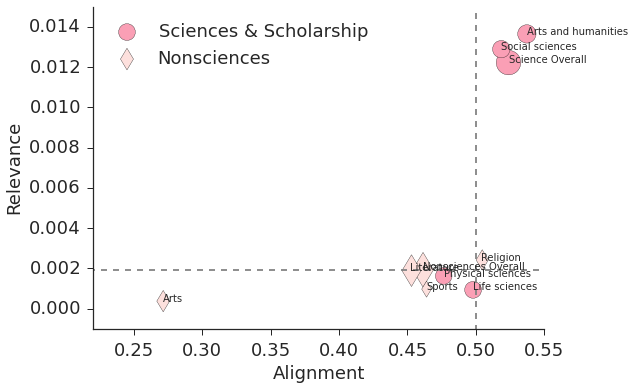

In [61]:
sns.set(style="ticks")
nodes=science.vs(depth_le=1)
science.vs.find('Sciences')['label']='Science Overall'
plt.scatter(zip(*nodes['color'])[0],
            nodes['relevance'],
            np.array(nodes['size'])**0.5,
            '#fa9fb5','o',label='Sciences & Scholarship')
for u in nodes:
    plt.text(u['color'][0],u['relevance'],u['label'])
nodes=nonscience.vs(depth_le=1)
nonscience.vs.find('Nonsciences')['label']='Nonsciences Overall'
plt.scatter(zip(*nodes['color'])[0],
            nodes['relevance'],
            np.array(nodes['size'])**0.5,
            '#fde0dd','d',label='Nonsciences')
plt.legend(loc=2,fontsize=18, markerscale=0.8,scatterpoints=1,numpoints=1)
for u in nodes:
    plt.text(u['color'][0],u['relevance'],u['label'])
plt.ylim([-0.001,0.015]);
plt.xlim([0.22,0.55])
sns.despine()
plt.plot([0.2,0.6],[df[df['depth']<=1]['relevance'].median()]*2,'--',color='grey')
plt.plot([0.5,0.5],[-0.01,0.02],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Alignment',fontsize=18)
plt.ylabel('Relevance',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/alignmentxrelevance.pdf')

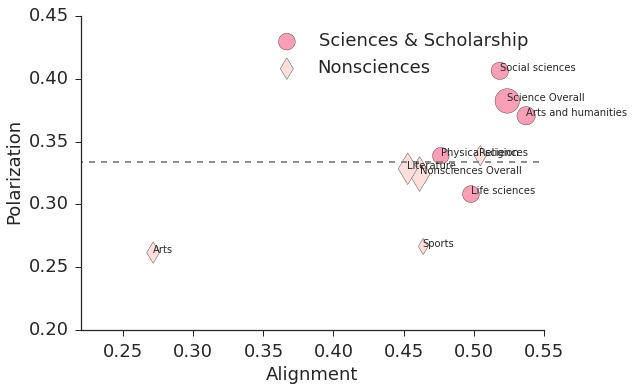

In [66]:
sns.set(style="ticks")
science.vs.find('Sciences')['label']='Science Overall'
nodes=science.vs(depth_le=1)
plt.scatter(zip(*nodes['color'])[0],
            nodes['polarization'],
            np.array(nodes['size'])**0.5,
            '#fa9fb5','o')
for u in nodes:
    plt.text(u['color'][0],u['polarization'],u['label'])
nonscience.vs.find('Nonsciences')['label']='Nonsciences Overall'
nodes=nonscience.vs(depth_le=1)
plt.scatter(zip(*nodes['color'])[0],
            nodes['polarization'],
            np.array(nodes['size'])**0.5,
            '#fde0dd','d')
plt.legend(['Sciences & Scholarship','Nonsciences'],loc='best',fontsize=18, markerscale=0.8,scatterpoints=1)
for u in nodes:
    plt.text(u['color'][0],u['polarization'],u['label'])
#plt.ylim([0.63,0.70]);
plt.xlim([0.22,0.55])
sns.despine()
plt.plot([0.2,0.6],[df[df['depth']<=1]['polarization'].median()]*2,'--',color='grey')
#plt.plot([0.5,0.5],[0,1],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Alignment',fontsize=18)
plt.ylabel('Polarization',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/alignmentxpolarization.pdf')

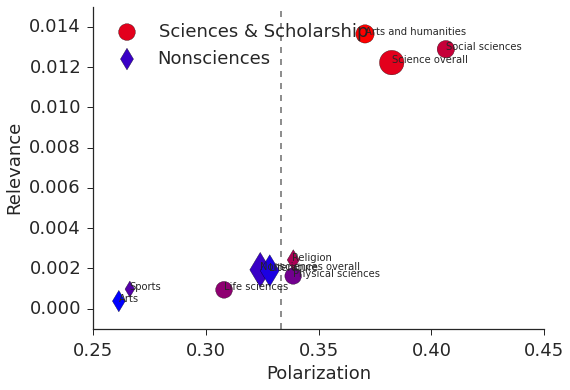

In [71]:
sns.set(style="ticks")
#cmin=min(zip(*D_com.vs(depth_le=1)['color'])[0]+zip(*N_com.vs(depth_le=1)['color'])[0])
#cmax=max(zip(*D_com.vs(depth_le=1)['color'])[0]+zip(*N_com.vs(depth_le=1)['color'])[0])
#cm=[[(c[0]-cmin)/(cmax-cmin),0,(cmax-c[0])/(cmax-cmin)] for c in D_com.vs(depth_le=1)['color']+N_com.vs(depth_le=1)['color']]
nodes1=science.vs(depth_le=1)
nodes2=nonscience.vs(depth_le=1)
cm=np.linspace(0,1,10)[stats.rankdata(zip(*nodes1['color'])[0]+zip(*nodes2['color'])[0]).astype(int)-1]
cm=zip(cm,[0]*len(cm),1-cm)
science.vs.find('Sciences')['label']='Science overall'
plt.scatter(nodes1['polarization'],
            nodes1['relevance'],
            np.array(nodes1['size'])**0.5,
            cm[:len(nodes1)],'o')
for u in nodes1:
    plt.text(u['polarization'],u['relevance'],u['label'])
nonscience.vs.find('Nonsciences')['label']='Nonsciences overall'
plt.scatter(nodes2['polarization'],
            nodes2['relevance'],
            np.array(nodes2['size'])**0.5,
            cm[len(nodes1):],'d')
plt.legend(['Sciences & Scholarship','Nonsciences'],loc=2,fontsize=18, markerscale=0.8,scatterpoints=1)
for u in nodes2:
    plt.text(u['polarization'],u['relevance'],u['label'])
plt.ylim([-0.001,0.015]);
#plt.xlim([0.63,0.70])
sns.despine()
#plt.plot([0.63,0.70],[df[df['depth']<=1]['relevance'].median()]*2,'--',color='grey')
plt.plot([df[df['depth']<=1]['polarization'].median()]*2,[-0.001,0.02],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('Relevance',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/polarizationxrelevance.pdf')

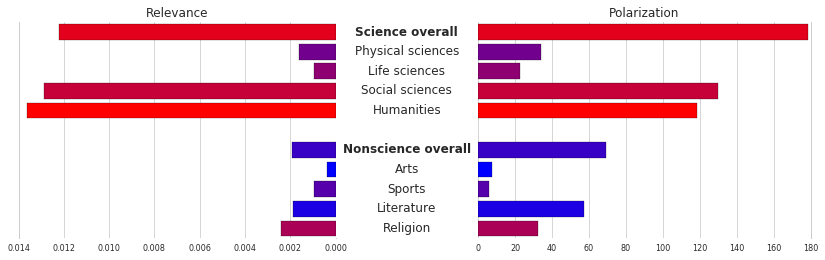

In [325]:
sns.set(style="whitegrid", context="paper")
science=D_loc
nodes1=science.vs(depth_le=1)
nodes2=nonscience.vs(depth_le=1)
science.vs.find('Sciences')['label']='Science overall'
nonscience.vs.find('Nonsciences')['label']='Nonscience overall'
labels=np.array(nodes1['label']+nodes2['label'])
pos=-np.hstack([np.arange(len(nodes1['label'])), np.arange(len(nodes1['label']), len(labels))+1])
x=np.array(nodes1['relevance']+nodes2['relevance'])
x2=np.array(nodes1['polarization']+nodes2['polarization'])
#cm=np.array(sns.color_palette("RdBu_r",len(labels)))
# cm=np.array([[ 0.11864668,  0.3       ,  0.64567476],
#        [ 0.21431928,  0.3       ,  0.59215688],
#        [ 0.30999189,  0.3       ,  0.538639  ],
#        [ 0.40566449,  0.3       ,  0.48512112],
#        [ 0.5013371 ,  0.3       ,  0.43160324],
#        [ 0.5970097 ,  0.3       ,  0.37808537],
#        [ 0.69268231,  0.3       ,  0.32456749],
#        [ 0.78835491,  0.3       ,  0.27104961],
#        [ 0.88402752,  0.2       ,  0.21753173],
#        [ 0.97970012,  0.15      ,  0.1       ]])
cm=np.vstack([np.linspace(0,1,len(labels)), np.repeat(0,len(labels)), np.linspace(1,0,len(labels))]).T
c=cm[stats.rankdata(zip(*nodes1['color'])[0]+zip(*nodes2['color'])[0]).astype(int)-1]
#sns.barplot(y,labels,orient='h',ax=ax[1])
fig=plt.figure(figsize=(11,3))
ax0=plt.axes([0,0,0.4,1])
ax0.invert_xaxis()
ax0.barh(pos,x,color=c,align='center')
#ax0.yaxis.tick_right()
#plt.yticks(pos, labels)
ax0.set_ylim([-10.5,0.5])
#ax0.get_xaxis().set_visible(False);
ax0.get_yaxis().set_visible(False);
sns.despine(ax=ax0,left=False,bottom=True,right=False)
ax0.set_title('Relevance',fontsize='larger')
ax1=plt.axes([0.58,0,0.42,1])
ax1.barh(pos,x2,color=c,align='center')
#ax1.set_xlim([0.25,0.41]);
ax1.set_ylim([-10.5,0.5]);
#ax1.get_xaxis().set_visible(False);
ax1.get_yaxis().set_visible(False);
sns.despine(ax=ax1,left=True,bottom=True,right=False)
ax1.set_title('Polarization',fontsize='larger')
ax2=plt.axes([0.4,0,0.18,1])
for i,y in enumerate(pos):
    #ax0.text(x[i]+0.0001,pos[i],'{:.2}'.format(x[i]),ha='right',va='center')
    #ax1.text(x2[i]+0.001,pos[i],'{:.2}'.format(x2[i]),ha='left',va='center')
    if labels[i]=='Science overall' or labels[i]=='Nonscience overall':
        ax2.text(0,y,labels[i],size='larger',weight='bold',ha='center',va='center')
    else:
        ax2.text(0,y,labels[i],size='larger',ha='center',va='center')
ax2.set_xlim([-1,1]);
ax2.set_ylim([-10.5,0.5]);
ax2.get_xaxis().set_visible(False);
ax2.get_yaxis().set_visible(False);
sns.despine(ax=ax2,bottom=True,left=True)
#plt.savefig('../Disciplines/polarizationrelevance.pdf',bbox_inches='tight')

#### Scientific disciplines

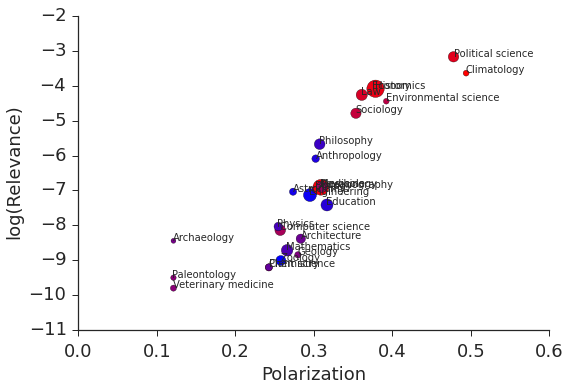

In [72]:
sns.set(style="ticks")
nodes=science.vs(depth=2)
cm=np.linspace(0,1,len(nodes))[stats.rankdata(zip(*nodes['color'])[0]).astype(int)-1]
cm=zip(cm,[0]*len(cm),1-cm)
science.vs.find('Sciences')['label']='Sciences & scholarship'
plt.scatter(nodes['polarization'],
            np.log(nodes['relevance']),
            np.array(nodes['size'])**0.5,
            cm,'o')
for u in nodes:
    plt.text(u['polarization'],np.log(u['relevance']),u['label'])
#plt.ylim([-10,-3]);
#plt.xlim([0.62,0.74])
sns.despine()
#plt.plot([0.6,0.8],[np.median(np.log(nodes['relevance']))]*2,'--',color='grey')
#plt.plot([np.median(nodes['polarization'])]*2,[-10,-3],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('log(Relevance)',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/polarizationXrelevance_27disciplines.pdf')

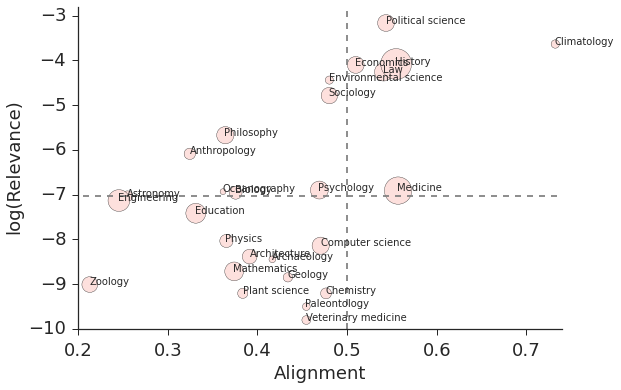

In [73]:
sns.set(style="ticks")
nodes=science.vs(depth=2)
science.vs.find('Sciences')['label']='Sciences & scholarship'
plt.scatter(zip(*nodes['color'])[0],
            np.log(nodes['relevance']),
            np.array(nodes['size'])**0.6,
            '#fde0dd','o')
for u in nodes:
    plt.text(u['color'][0],np.log(u['relevance']),u['label'],fontsize=10)
plt.ylim([-10,-2.8]);
plt.xlim([0.2,0.74])
sns.despine()
plt.plot([0.1,1],[np.median(np.log(nodes['relevance']))]*2,'--',color='grey')
plt.plot([0.5,0.5],[-10,10],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Alignment',fontsize=18)
plt.ylabel('log(Relevance)',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/alignmentXrelevance_27disciplines.pdf')

In [75]:
def drawTree(T,figsize=(8,8),root=0,depth=2,layout='horizontal'):
    step=2*np.pi/(len(T.vs.select(depth=depth))+1)
    fig = plt.figure(figsize=figsize)
    if layout=='polar':
        ax = plt.subplot(111, projection='polar')
    plt.axis('off');

    def draw(T,root,pos,level,depth,step):
        maxx=pos
        xs=[]
        color=T.vs[root]['color']
        color[1]=color[2]/2
        child=T.neighbors(root,OUT)
        if child and T.vs[root]['depth']<depth:
            child=sorted(child,key=lambda c: T.vs[c]['color'][0])
            for i in xrange(len(child)):
                u=child[i]
                if i==0:
                    xc,maxx=draw(T,u,maxx,level+1,depth,step)
                else:
                    xc,maxx=draw(T,u,maxx+step,level+1,depth,step)
                xs.append(xc)
                if layout=='vertical':
                    plt.plot([xc]*2,[-(level+0.5),-(level+1)],'lightgrey',zorder=1)
                elif layout=='horizontal':
                    plt.plot([level+0.5,level+1],[xc]*2,'lightgrey',zorder=1)
                elif layout=='polar':
                    plt.plot([xc]*2,[(level+0.5),(level+1)],'darkgrey',zorder=1)
            if layout=='vertical':
                plt.scatter(mean(xs),-level,s=100,c=color,zorder=2)
                plt.plot([xs[0],xs[-1]],[-(level+0.5)]*2,'lightgrey')
                plt.plot([np.mean(xs)]*2,[-level,-(level+0.5)],'lightgrey',zorder=1)
                plt.text(mean(xs),-level+0.1,"{}".format(T.vs[root]['label']),ha='center',va='bottom',fontsize=11,color=color)
                #plt.text(mean(xs),-level-0.05,"({:.2f})".format(T.vs[root]['color'][0]),ha='center',va='top',color=color)
            elif layout=='horizontal':   
                plt.scatter(level,mean(xs),s=100,c=color,zorder=2)
                plt.plot([level+0.5]*2,[xs[0],xs[-1]],'lightgrey')
                plt.plot([level,level+0.5],[np.mean(xs)]*2,'lightgrey',zorder=1)
                plt.text(level,mean(xs)+step,"{}".format(T.vs[root]['label']),ha='center',va='bottom',fontsize=14,color=color)
                plt.text(level,mean(xs)-step,"({:.2f})".format(T.vs[root]['color'][0]),ha='center',va='top',color=color)
            elif layout=='polar':
                plt.scatter(mean(xs),level,s=150,c=color,zorder=2)
                theta=np.linspace(xs[0],xs[-1],np.ceil((xs[-1]-xs[0])*30/np.pi))
                plt.plot(theta,[(level+0.5)]*len(theta),'darkgrey')
                plt.plot([np.mean(xs)]*2,[level,(level+0.5)],'darkgrey',zorder=1)
                plt.text(mean(xs),level+0.1,"{}".format(T.vs[root]['label']),ha='center',va='bottom',fontsize=16,color=color)
                #plt.text(mean(xs),level,"({:.2f})".format(T.vs[root]['color'][0]),ha='center',va='top',color=color)
        else:
            xs.append(pos)
            if layout=='vertical':
                plt.scatter(pos,-level,s=100,c=color,zorder=2)
                #plt.text(pos,-level-0.05,"{} ({:.2f})".format(T.vs[root]['label'],T.vs[root]['color'][0]),rotation=-90,ha='center',va='top',color=color)
                plt.text(pos,-level-0.1,"{}".format(T.vs[root]['label']),rotation=-90,ha='center',va='top',color=color)
            elif layout=='horizontal': 
                plt.scatter(level,pos,s=100,c=color,zorder=2)
                plt.text(level+0.06,pos,"{} ({:.2f})".format(T.vs[root]['label'],T.vs[root]['color'][0]),ha='left',va='center',color=color)
            elif layout=='polar':
                plt.scatter(pos,level,s=150,c=color,zorder=2)
                #plt.text(pos,level+0.1,"{} ({:.2f})".format(T.vs[root]['label'],T.vs[root]['color'][0]),rotation=pos/np.pi*180+180 if pos>np.pi/2 else pos/np.pi*180,ha='right' if pos>np.pi/2 else 'left',va='bottom' if pos>0 and pos<np.pi else 'top',fontsize=16,color=color)
                plt.text(pos,level+0.1,"{}".format(T.vs[root]['label']),rotation=pos/np.pi*180+180 if pos>np.pi/2 else pos/np.pi*180,ha='right' if pos>np.pi/2 else 'left',va='bottom' if pos>0 and pos<np.pi else 'top',fontsize=16,color=color)
        return np.mean(xs),maxx
    
    draw(T,root,-np.pi/2,0,depth,step)
    #plt.savefig('../Disciplines/tree.pdf')

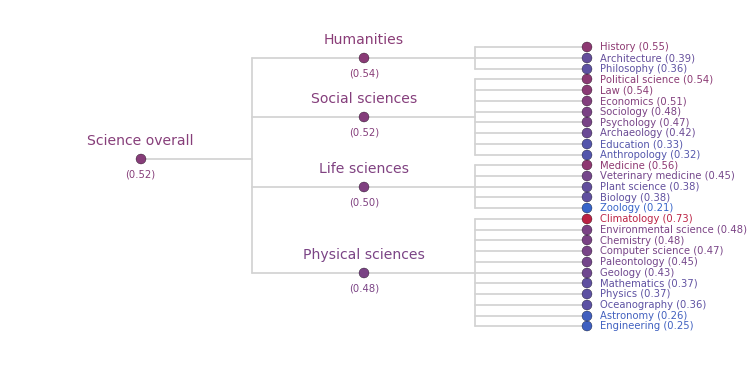

In [76]:
drawTree(D_loc,layout='horizontal',figsize=(12,6))

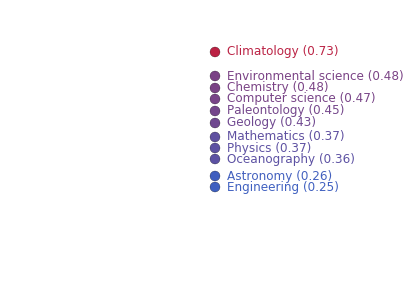

In [651]:
T=D_loc;
child=T.neighbors(T.vs.find('Physical sciences'),OUT);
child=sorted(child,key=lambda c: T.vs[c]['color'][0]);
gap=0.004;
u=T.vs[child[0]];
color=u['color'];
y=color[0];
plt.scatter(0,color[0],s=100,c=color);
plt.text(0.001,color[0],"{} ({:.2f})".format(u['label'],color[0]),ha='left',va='center',color=color,fontsize=12);
for i in range(1,len(child)):
    u=T.vs[child[i]];
    color=u['color'];
    y+=(T.vs[child[i]]['color'][0]-T.vs[child[i-1]]['color'][0])/50+gap;
    plt.scatter(0,y,s=100,c=color);
    plt.text(0.001,y,"{} ({:.2f})".format(u['label'],color[0]),ha='left',va='center',color=color,fontsize=12);
plt.axis('off');
plt.savefig('../Disciplines/physical_branch.pdf',bbox_inches='tight')

#### Applied vs Alignment

In [88]:
science=D_dd
nodes=science.vs[science.neighborhood(science.vs.find('Physical sciences'), order=2, mode='out')+science.neighborhood(science.vs.find('Life sciences'), order=2, mode='out')]
df=pd.DataFrame({"patentCites": nodes['patentCites'],
                 "journalCites": nodes['journalCites'],
                 "alignment": zip(*nodes['color'])[0],
                 "size": nodes['relevance'],
                 'relevance': nodes['psize'],
                 "label": nodes['label'], 
                 "name": nodes['name']})
df=df[df['relevance']>0]

In [89]:
print df[df.name.str.endswith('0')].to_string()
print df[df.name=='629'].to_string()
df=df[~df.name.str.endswith('0')]
df=df[df.name!='629']
df=df.reset_index(drop=True)

     alignment  journalCites                                        label name  patentCites  relevance      size
18    0.412611           319                                  Mathematics  510          825         12  0.000183
29    0.384716           235                  Astronomy & allied sciences  520           62         11  0.000896
40    0.392216           335                                      Physics  530        50233         26  0.000305
51    0.427511           299                  Chemistry & allied sciences  540        35515          9  0.000154
62    0.125000           256                               Earth sciences  550          112          3  0.000191
84    0.250000           296  Chemical engineering & related technologies  660        31044          1  0.000130
95    0.913900           330             Engineering & Applied operations  620        13503          3  0.000430
112   0.293340           381                                      Biology  570         9448     

In [90]:
df=df[df['patentCites']!=0]
fitted = sm.OLS(np.log(df['patentCites']),sm.add_constant(df['journalCites'])).fit()
df['applied']=df['patentCites']/np.exp(fitted.predict(sm.add_constant(df['journalCites'])))

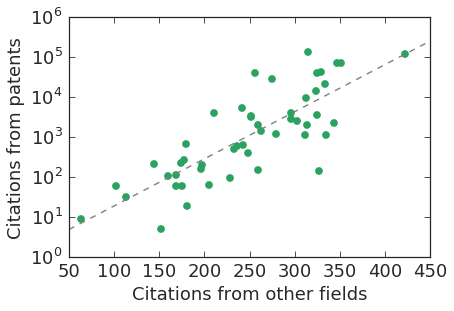

In [91]:
sns.set_style('ticks',{'xtick.direction':'in','ytick.direction':'in'})
sns.set_context(context='paper')
#sns.regplot(df['journalCites'],np.log(df['patentCites']), ci=90, truncate=False,
#            line_kws={'color':'grey', 'lw':2},
#            scatter_kws={'s':50, 'c':'#2ca25f'});
plt.scatter(df['journalCites'], df['patentCites'], s=60, c='#2ca25f', lw = 0)
plt.plot([50,450], np.exp(fitted.predict(sm.add_constant([50,450]))), '--',color='grey')
plt.yscale('log')
plt.xlim([50,450])
#plt.ylim([0,14])
plt.minorticks_off();
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Citations from other fields',fontsize=18)
plt.ylabel('Citations from patents',fontsize=18);
#sns.despine();
plt.tight_layout();

In [94]:
fitted2 = sm.OLS(np.log(df['applied']),sm.add_constant(df['alignment'])).fit()

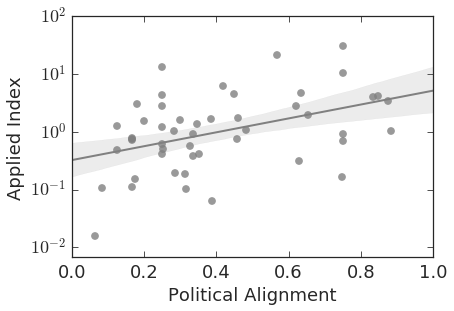

In [95]:
sns.regplot(df['alignment'],np.log(df['applied']), ci=90, truncate=False,
            line_kws={'color':'grey', 'lw':2},
            scatter_kws={'s':60, 'c':'gray'});
#for i in xrange(len(df)):
#    plt.text(df['alignment'].iloc[i],np.log(df['applied'].iloc[i]),df['label'].iloc[i],fontsize=10,color='grey')
#plt.scatter(df['alignment'], df['applied'], s=60, c='#2ca25f', lw = 0)
#plt.plot([0,1],np.exp(fitted2.predict(sm.add_constant([0,1]))), '--',color='grey')
#plt.yscale('log')
#plt.ylim([0.01,100])
plt.xlim([0,1])
plt.minorticks_off();
plt.yticks(np.log([0.01,0.1,1,10,100]),['$10^{-2}$','$10^{-1}$','$10^0$','$10^1$','$10^2$'])
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Political Alignment',fontsize=18);
plt.ylabel('Applied Index',fontsize=18);
#sns.despine();
plt.tight_layout();
#plt.savefig('../Disciplines/applied.pdf');

In [96]:
print "Correlation between citations by patents and by other categories: {}\nCorrelation between applied index and political index: {}".format(
            stats.pearsonr(df['journalCites'], np.log(df['patentCites'])),
            stats.pearsonr(np.log(df['applied']),(df['alignment'])))

Correlation between citations by patents and by other categories: (0.80497837407409989, 3.1415262260934945e-12)
Correlation between applied index and political index: (0.42748680539434036, 0.0021863355138492559)


#### Academic vs popular

In [ ]:
nodes=science.vs(depth=2)
x=zip(*nodes['color'])[0]
y=(np.array(nodes['blueacademic'])+1)/(np.array(nodes['redacademic'])+1)
plt.scatter(x,y,
            -np.log(nodes['relevance'])*30,
            'red','o')
labels=nodes['label']
for xi,yi,l in zip(x,y,labels):
    plt.text(xi,yi,l,fontsize=10)
stats.pearsonr(x,y)

In [ ]:
import matplotlib.ticker as mtick
sns.set(style="whitegrid", context="talk")
nodes=science.vs(depth=2)
x=zip(*nodes['color'])[0]
y=(np.array(nodes['blueacademic'])+1)/(np.array(nodes['redacademic'])+1)-1
labels=np.array(nodes['label'])
ax=sns.barplot(labels, y, x_order=labels[np.argsort(x)], palette="RdBu_r")
sns.despine(bottom=True,left=True)
_, labels = plt.xticks()
plt.setp(labels, rotation='vertical')
plt.ylim(-0.1,1.01);
baseline = 1
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+baseline))

#### Scientific breadth

In [40]:
science=D_loc
nodes=science.vs(depth=2)
df=pd.DataFrame({"blue": nodes['bluebreadth'],
                 "red": nodes['redbreadth'],
                 "relevance": nodes['psize'],
                 "size": nodes['relevance'],
                 "label": nodes['label'], 
                 "polarization": nodes['polarization'],
                 "name": nodes['name']})
df['school']=df['name'].map(lambda x: x.split('/')[0])
minRel=2
df=df[df['relevance']>minRel]
df['ratio']=df['blue']-df['red']
df['logp']=np.log(df['polarization'])
fitted = sm.OLS(df['ratio'], sm.add_constant(np.log(df['polarization']))).fit()

(0.78896717115939208, 4.6217758669153248e-06)


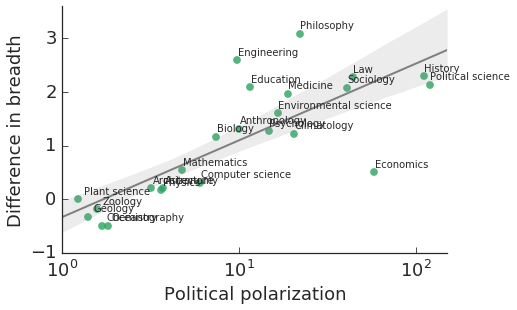

In [53]:
sns.set_style('ticks',{'xtick.direction':'in','ytick.direction':'in'})
sns.set_context(context='paper')
fig,ax=plt.subplots()
#plt.scatter(df['polarization'], df['ratio'], s=60, c='#2ca25f', lw = 0)
#plt.plot([df['polarization'].min(),df['polarization'].max()],
#         fitted.predict(sm.add_constant(np.log([df['polarization'].min(),df['polarization'].max()]))),
#         '--', color='grey')
plt.xscale('log')
plt.minorticks_off()
plt.xlim([1,150])
plt.ylim([-1,3.6])
sns.regplot('polarization','ratio', data=df, ci=90, truncate=False, logx=True,
            #scatter_kws={'s':1/(-np.log(df['size']))*800},
            scatter_kws={'s':60, 'c':'#2ca25f'},
            line_kws={'color':'grey', 'lw':2}, ax=ax)
for i in xrange(len(df)):
    plt.text(df['polarization'].iloc[i]+0.1,df['ratio'].iloc[i]+0.1,df['label'].iloc[i],fontsize=10)
#plt.plot([x.min(),x.max()],[np.log(2),np.log(2)],'--')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Political polarization',fontsize=18)
#plt.ylabel('Difference between numbers\nof blue- and red-linked books',fontsize=18);
plt.ylabel('Difference in breadth',fontsize=18);
sns.despine(trim=False);
plt.tight_layout()
print stats.pearsonr(np.log(df['polarization']), df['ratio'])
#plt.savefig('../Disciplines/breadth.pdf')

#### Closeness

In [181]:
science=D_loc
nodes=science.vs(depth=2)
df=pd.DataFrame({"blue": nodes['blueclose1'],#map(lambda x: np.median(np.array(x)[np.array(x)>0.01]) if len(x)>1 else 0, nodes['blueclose']),
                 "red": nodes['redclose1'],#map(lambda x: np.median(np.array(x)[np.array(x)>0.01]) if len(x)>0 else 0, nodes['redclose']),
                 "relevance": nodes['psize'],
                 "size": nodes['relevance'],
                 "label": nodes['label'], 
                 "polarization": nodes['polarization'],
                 "diffstd": [ np.sqrt(np.var(u['blueclose']+u['redclose'])*(1.0/len(u['blueclose'])+1.0/len(u['redclose']))) if len(u['redclose'])>0 else 0 for u in nodes]})
minRel=2
df=df[df['relevance']>minRel]
df['ratio']=(df['blue']-df['red'])
df['zscore']=(df['blue']-df['red'])/df['diffstd']

(0.27765487029391395, 0.18897481015502426)

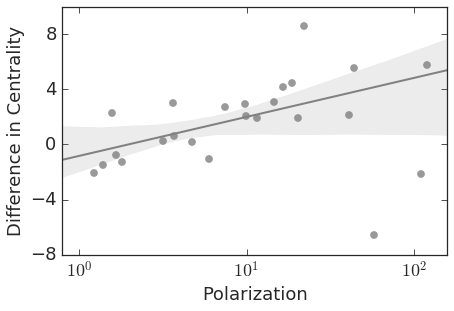

In [208]:
#sns.set_style('ticks',{'xtick.direction':'in','ytick.direction':'in'})
#sns.set_context(context='notebook')
#plt.scatter(np.log(df['polarization']), df['ratio'],
#            s=1/(-np.log(df['size']))*800, c='#2b8cbe', lw = 0)
#plt.plot(np.log(df['polarization']),model.predict())
sns.regplot(np.log10(df['polarization']),df['zscore'], ci=90, truncate=False, robust=True, #logx=True, 
            scatter_kws={'s':60, 'c':'gray'},
            line_kws={'color':'grey', 'lw':2})
#for i in xrange(len(df)):
#    plt.text(df['polarization'].iloc[i],df['ratio'].iloc[i],df['label'].iloc[i],fontsize=10)
#plt.plot([x.min(),x.max()],[np.log(2),np.log(2)],'--')
#plt.xscale('log')
plt.xlim([-0.1,2.2])
plt.xticks(np.log10([1,10,100]),['$10^0$','$10^1$','$10^2$'])
plt.ylim([-8,10])
plt.gca().yaxis.set_major_locator(MaxNLocator(6))
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('Difference in Centrality',fontsize=18);
plt.tight_layout()
stats.pearsonr(np.log(df['polarization']), df['zscore'])

In [210]:
fitted = sm.OLS(df['zscore'], sm.add_constant(np.log(df['polarization']))).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 zscore   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.838
Date:                Thu, 03 Mar 2016   Prob (F-statistic):              0.189
Time:                        15:09:54   Log-Likelihood:                -60.432
No. Observations:                  24   AIC:                             124.9
Df Residuals:                      22   BIC:                             127.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.0587      1.246      0.047      0.963        -2.526     2.643
polarization     0.6470      0.477      1.356      0.189        -0.343     1.637
==============================================================================
Omnibus:                        9.395   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.286
Skew:                          -0.914   Prob(JB):                       0.0159
Kurtosis:                       5.223   Cond. No.                         5.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [211]:
fitted = sm.RLM(df['zscore'], sm.add_constant(np.log(df['polarization']))).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 zscore   No. Observations:                   24
Model:                            RLM   Df Residuals:                       22
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 03 Mar 2016                                         
Time:                        15:10:04                                         
No. Iterations:                    26                                         
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.8330      0.826     -1.009      0.313        -2.451     0.786
polarization     1.2278      0.316      3.882      0.000         0.608     1.848
================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

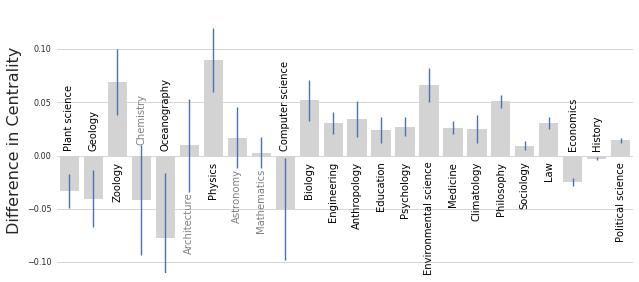

In [180]:
df=df.sort_values('polarization')
with sns.axes_style("whitegrid"):
    plt.figure(figsize=[9,4])
    sns.barplot(df['label'], df['ratio'],yerr=df['diffstd'], lw=0,color='lightgray')
    x, labels = plt.xticks()
    for i,y in enumerate(df['ratio']):
        if y>0:
            plt.text(i, min(-0.005, y-df.iloc[i]['diffstd']), labels[i].get_text(),rotation=90,ha='center',va='top',color='black' if y-df.iloc[i]['diffstd']>0 else 'grey')
        elif y<0:
            plt.text(i, max(0.005,y+df.iloc[i]['diffstd']), labels[i].get_text(),rotation=90,ha='center',va='bottom',color='black' if y+df.iloc[i]['diffstd']<0 else 'grey')
        else:
            plt.text(i, 0, labels[i].get_text(),rotation=90,ha='center',va='center')
    plt.xticks([])
    #plt.setp(labels, rotation='vertical', fontsize=14);
    sns.despine(bottom=True,left=True);
    plt.ylim([-0.11,0.14])
    plt.xlabel('')
    plt.ylabel('Difference in Centrality',fontsize=16)
    #plt.ylabel('Difference between centralities\nof blue- and red-linked books',fontsize=16)
    plt.tight_layout()
    #plt.savefig('../Disciplines/centrality.pdf')

In [69]:
df[df['polarization']<=np.median(df['polarization'])]['ratio'].mean(),df[df['polarization']<=np.median(df['polarization'])]['ratio'].std()/np.sqrt(len(df)/2.0)

(0.002836550586893105, 0.013160869408973966)

In [70]:
df[df['polarization']>np.median(df['polarization'])]['ratio'].mean(), df[df['polarization']>np.median(df['polarization'])]['ratio'].std()/np.sqrt(len(df)/2.0)

(0.01624334114025021, 0.0048842315612756607)

In [71]:
model = sm.OLS(df['ratio'], sm.add_constant(np.log(df['polarization']))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9052
Date:                Thu, 04 Feb 2016   Prob (F-statistic):              0.352
Time:                        10:49:16   Log-Likelihood:                 47.869
No. Observations:                  24   AIC:                            -91.74
Df Residuals:                      22   BIC:                            -89.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0012      0.013     -0.090      0.929        -0.029     0.026
polarization     0.0048      0.005      0.951      0.352        -0.006     0.015
==============================================================================
Omnibus:                        1.563   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                0.419
Skew:                           0.041   Prob(JB):                        0.811
Kurtosis:                       3.642   Cond. No.                         5.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [525]:
df2=pd.DataFrame()
df2['Topic']=df['label'].append(df['label']).astype('category')
df2['Closeness']=df['blue'].append(df['red'])
df2['Co-purchased with']=['blue']*len(df)+['red']*len(df)
df2['polarization']=df['polarization'].append(df['polarization'])

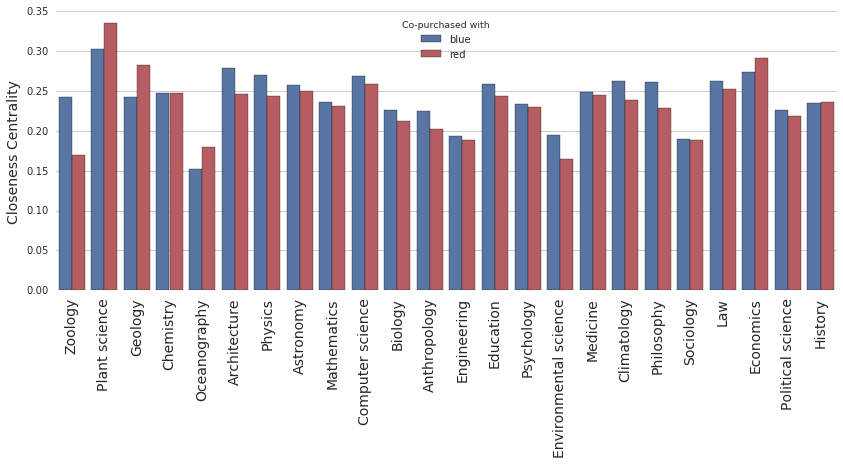

In [528]:
with sns.axes_style("whitegrid"):
    with sns.color_palette(sns.color_palette()[0:3:2]):
        plt.figure(figsize=[14,5])
        sns.barplot('Topic', 'Closeness', 'Co-purchased with', data=df2, order=df.sort_values('polarization')['label'])
        _, labels = plt.xticks()
        plt.setp(labels, rotation='vertical', fontsize=14);
        sns.despine(bottom=True,left=True);
        plt.xlabel('')
        plt.ylabel('Closeness Centrality',fontsize=14)

#### Polarization within each discipline

/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


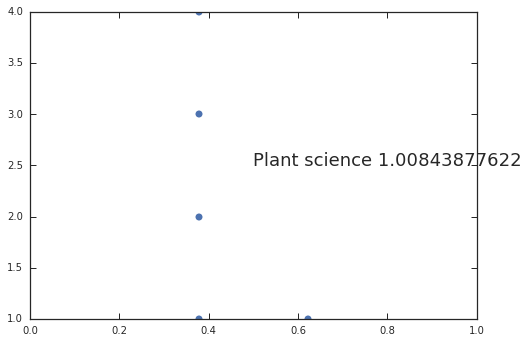

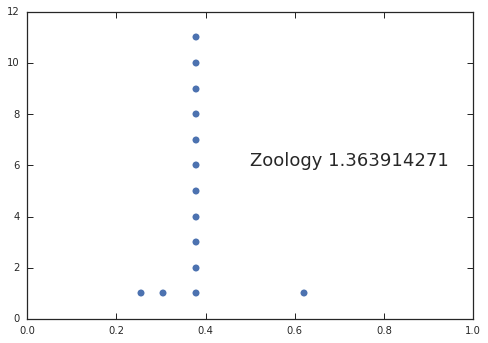

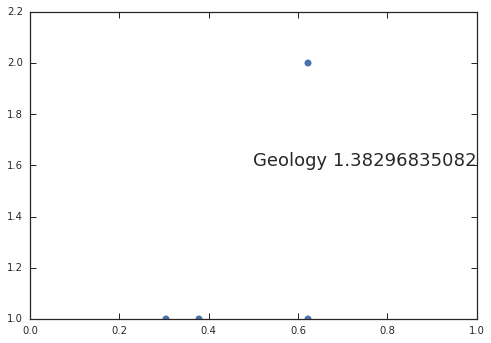

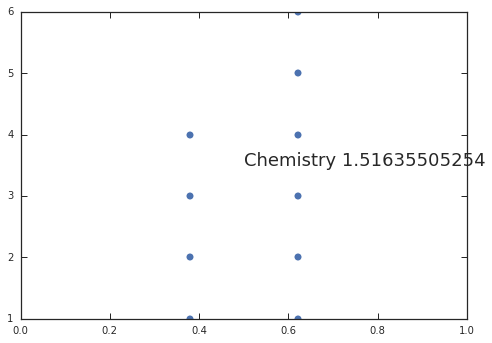

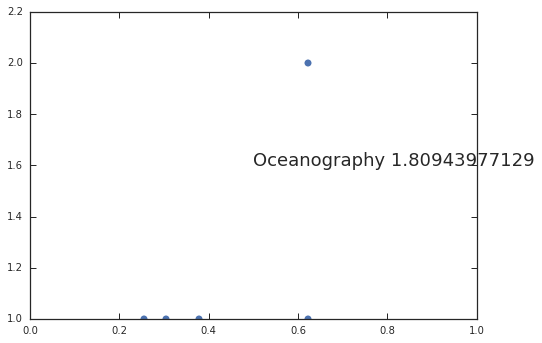

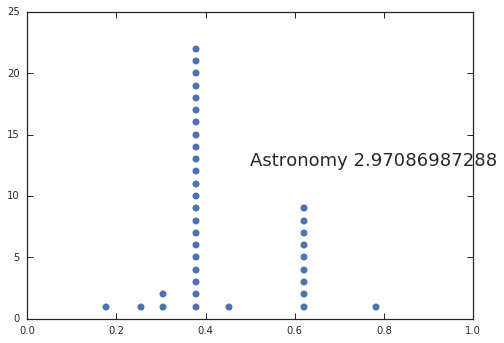

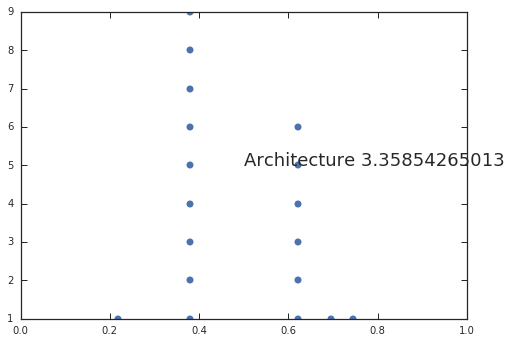

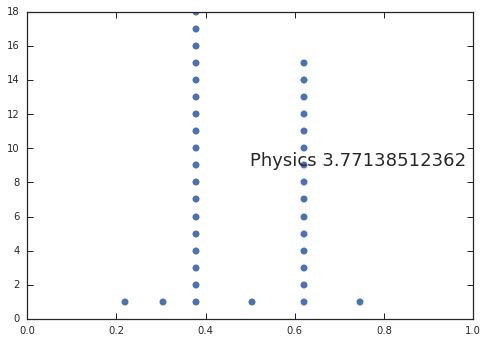

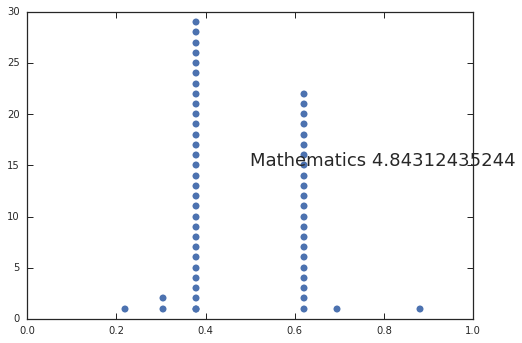

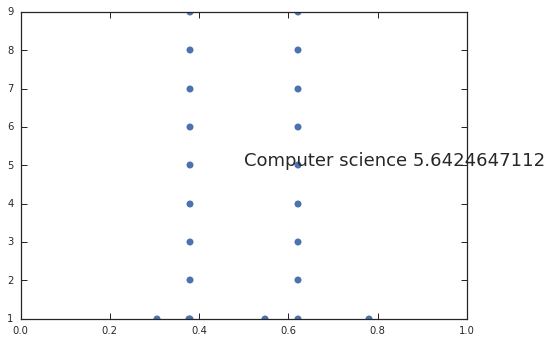

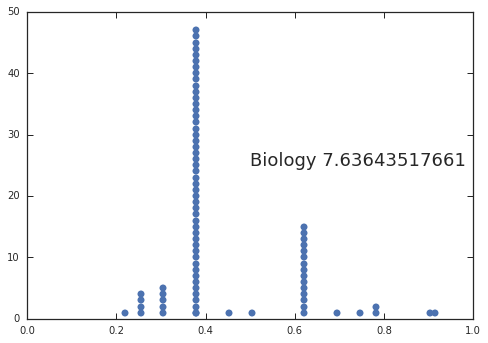

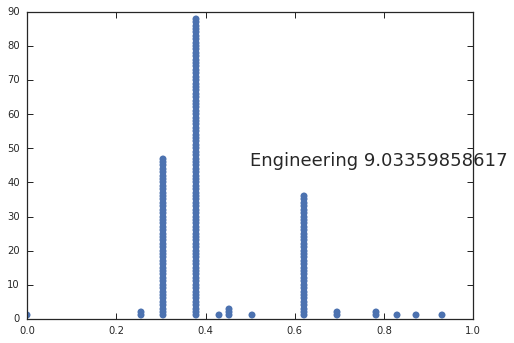

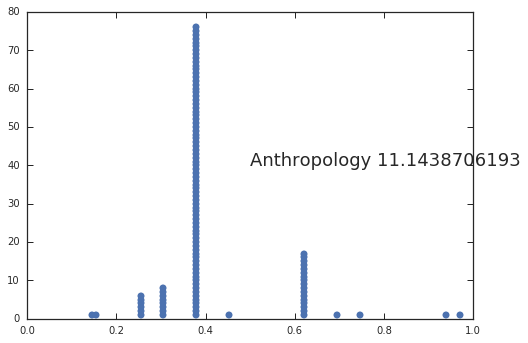

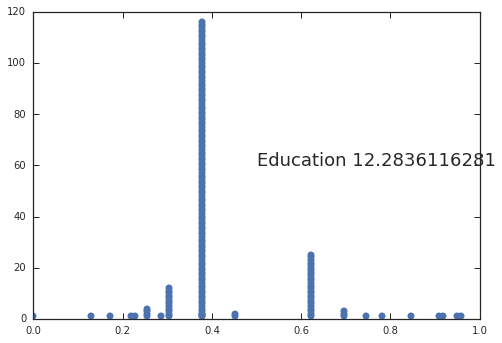

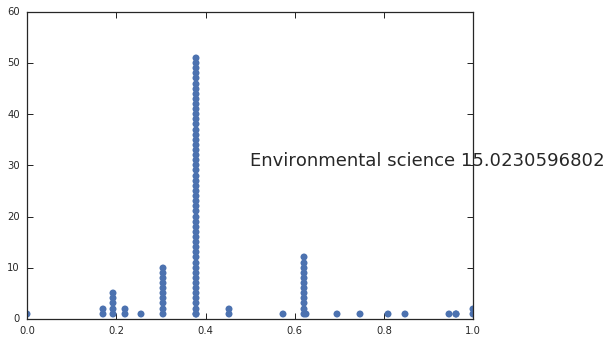

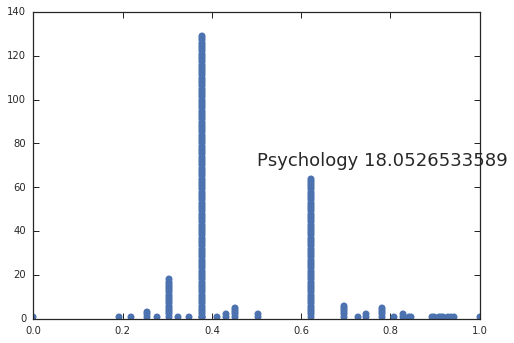

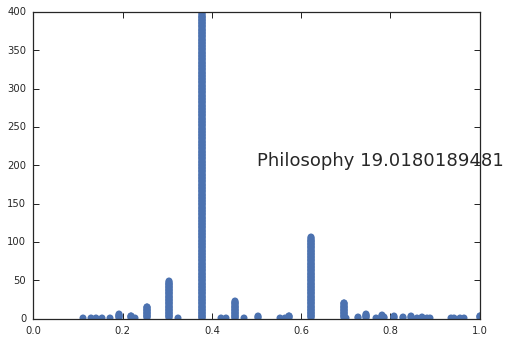

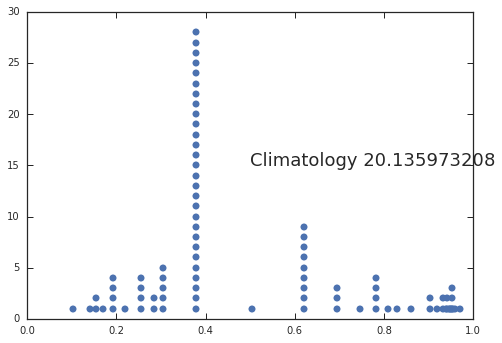

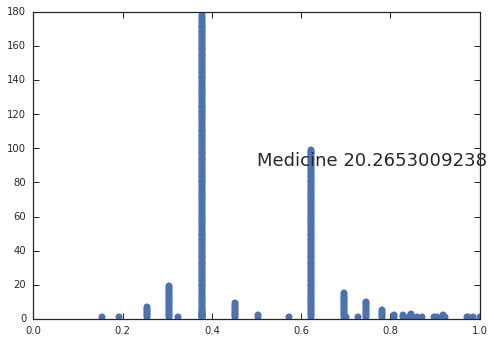

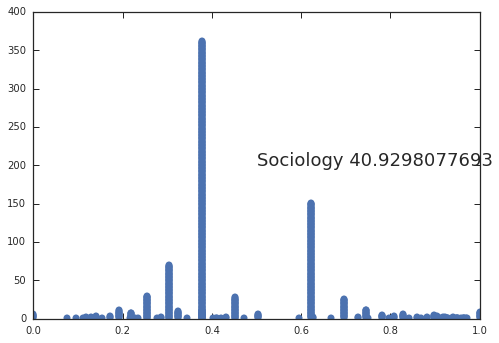

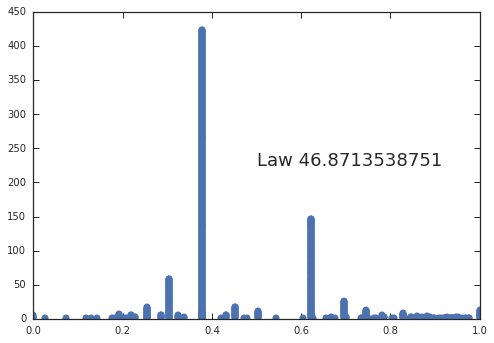

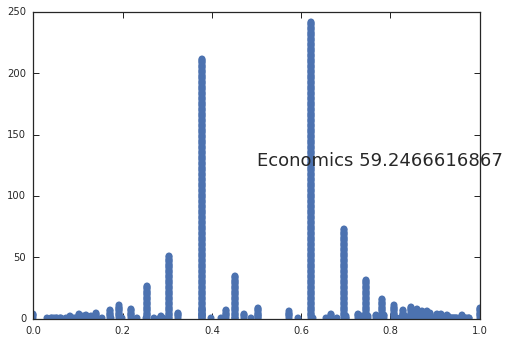

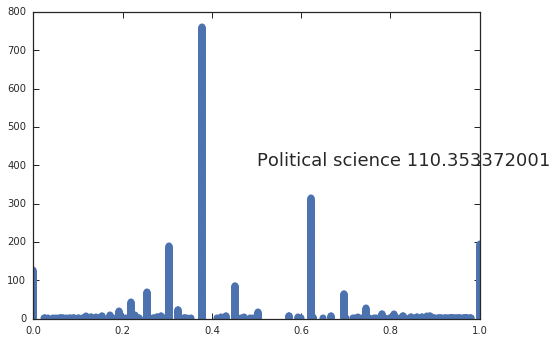

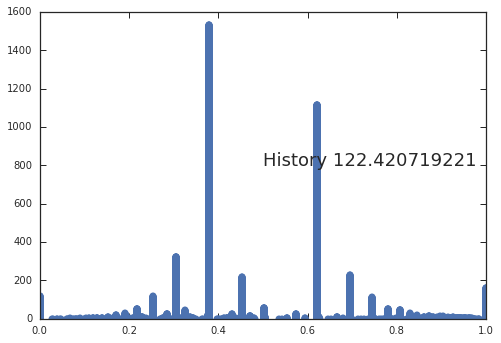

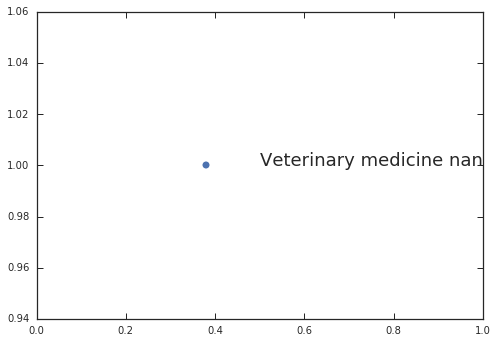

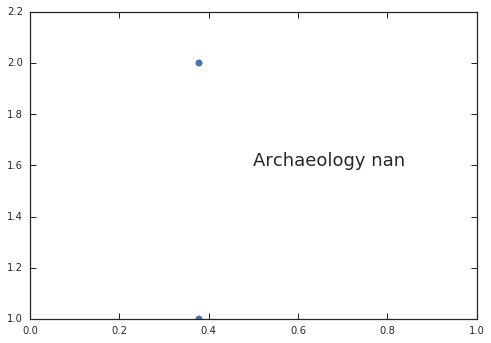

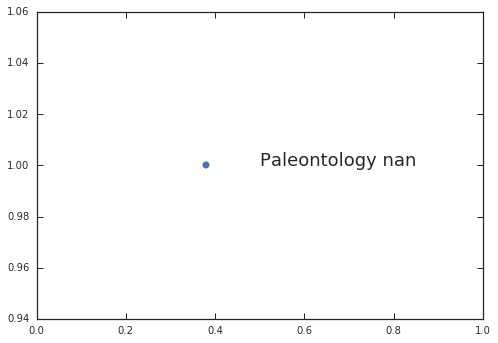

In [220]:
nodes=science.vs(depth=2)
pol=nodes['polarization']
for i in np.argsort(pol):
    df=pd.DataFrame([ [u['color'][0],u['close'],u['title'],u['academic']] 
                     for u in g.vs[list(nodes[i]['books'])] if u['close'] is not None], 
                      columns=['alignment','closeness','title','academic'])
    hist=Counter(df['alignment'])
    fig,ax=plt.subplots()
    ax.plot([x for x,y in hist.items() for l in range(y)],
             [l for y in hist.values() for l in range(1,y+1)],'o')
    #plt.plot(df.alignment,df.closeness,'.');
    plt.text(0.5,0.5,nodes[i]['label']+' '+str(nodes[i]['polarization']),fontsize=18,transform=ax.transAxes);
    plt.xlim([0,1])

#### Book closenness within each discipline

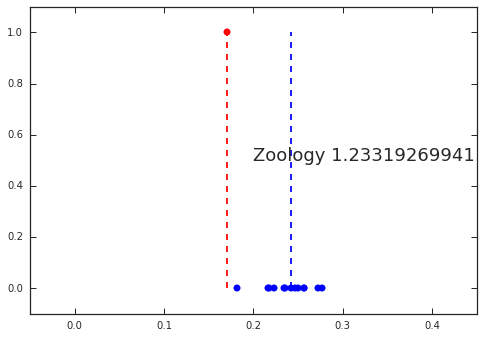

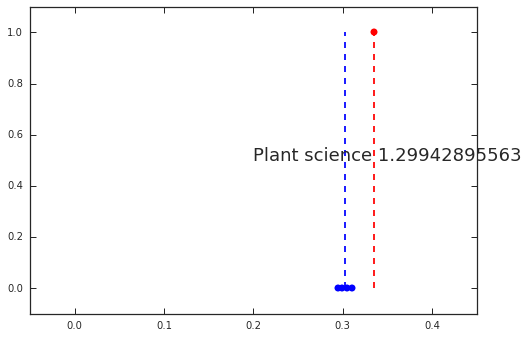

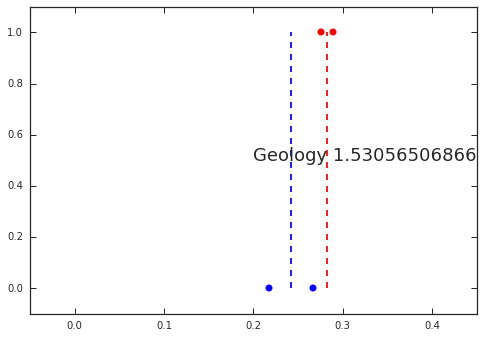

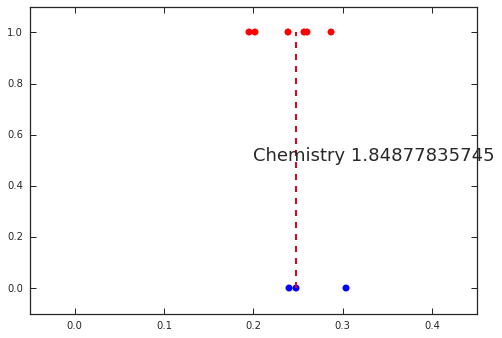

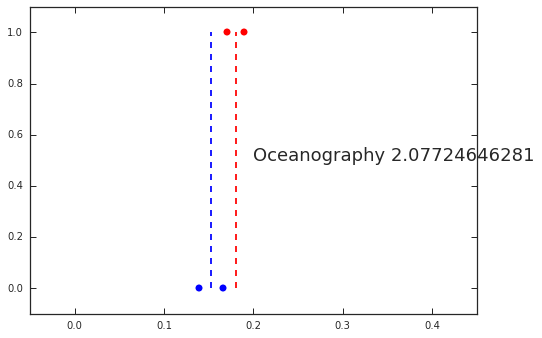

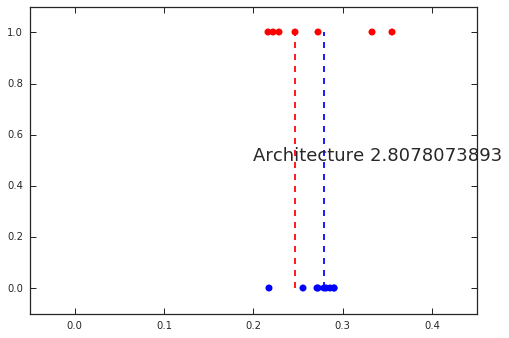

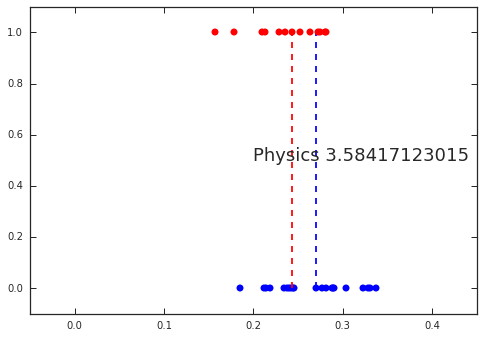

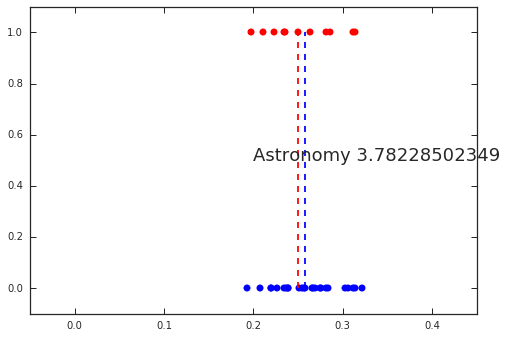

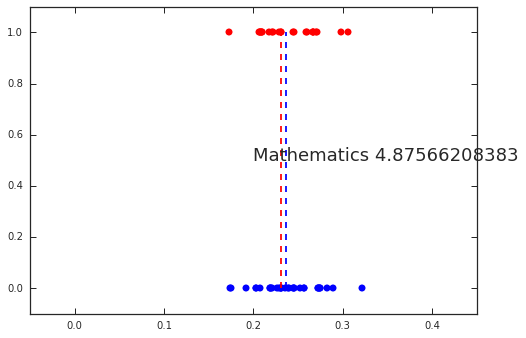

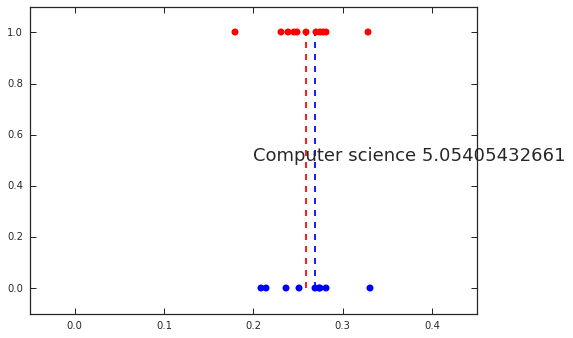

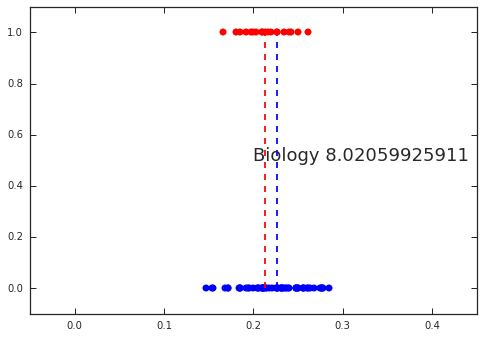

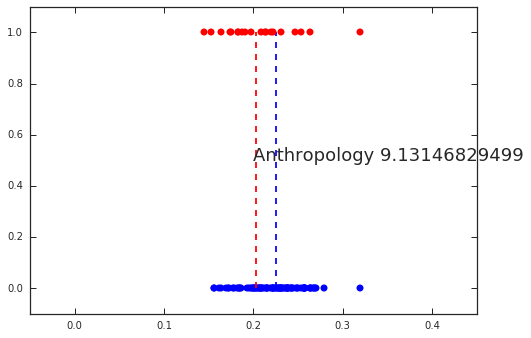

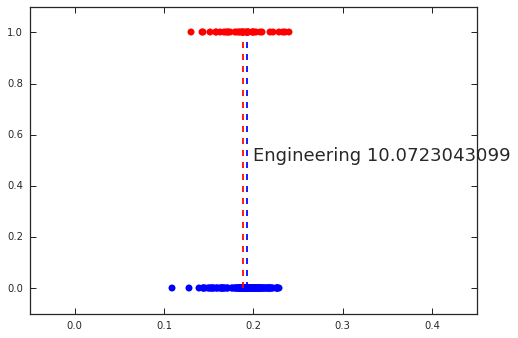

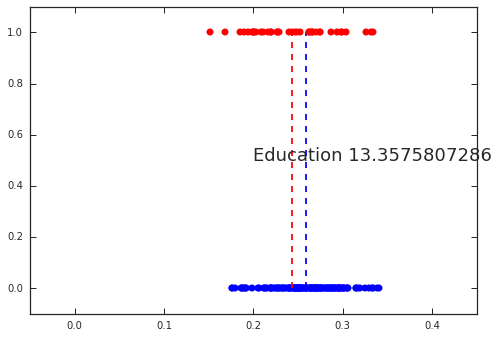

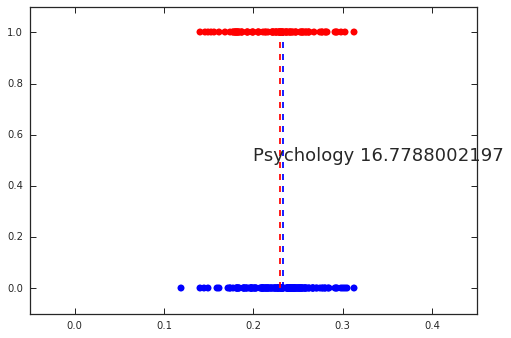

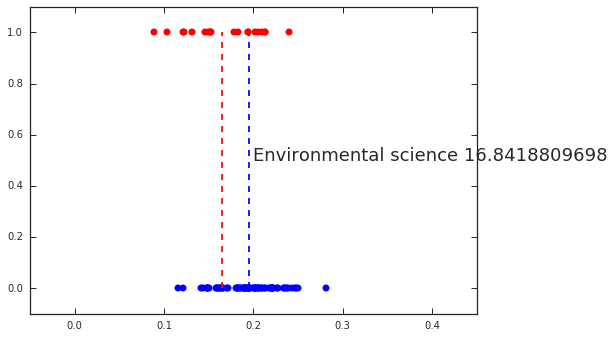

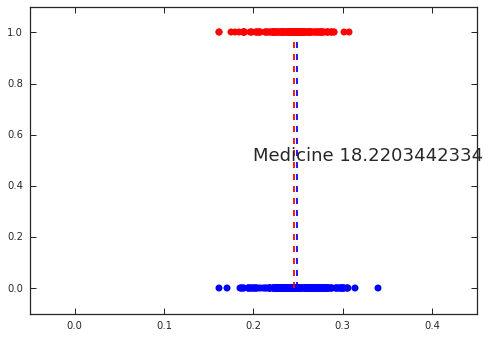

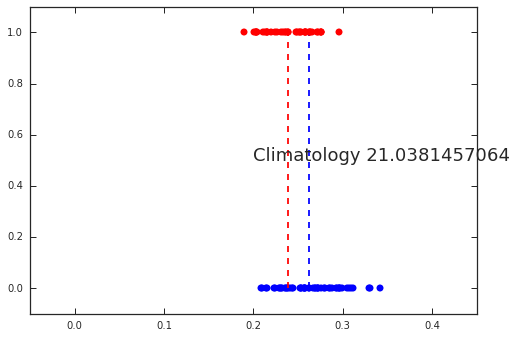

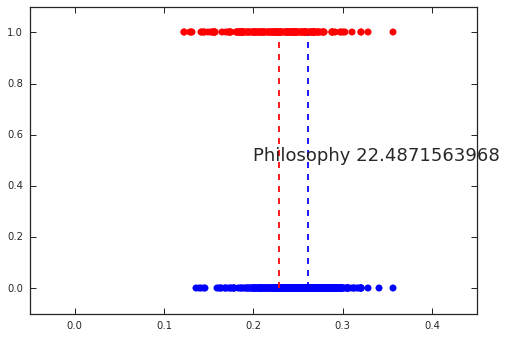

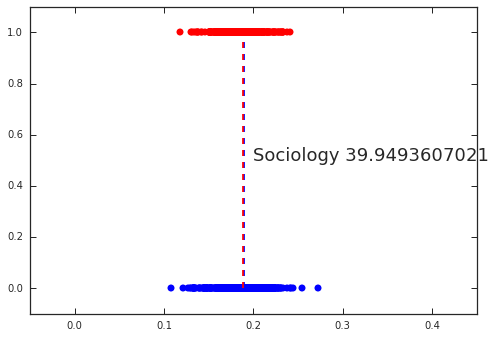

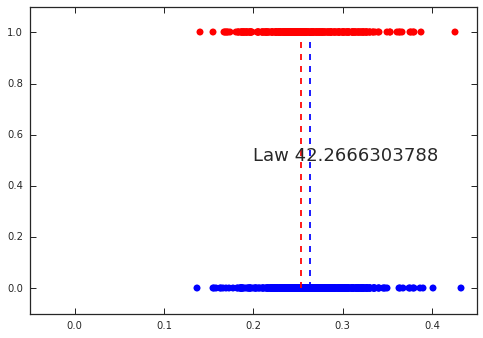

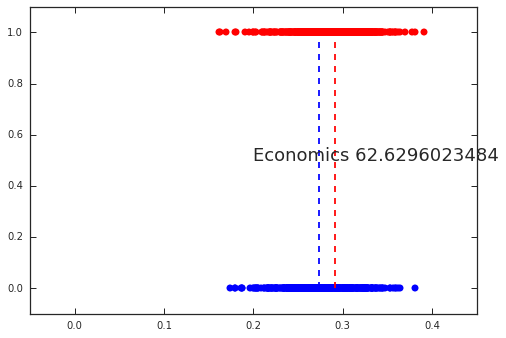

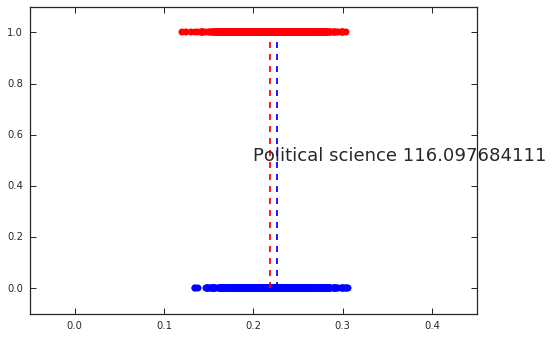

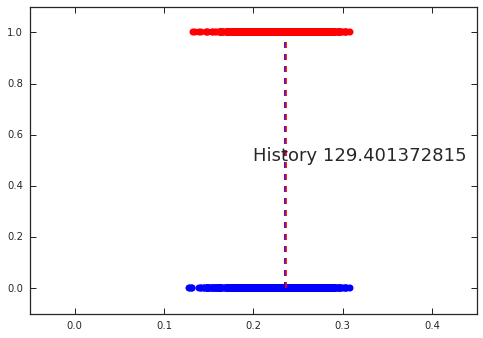

In [432]:
nodes=science.vs(depth=2)
pol=nodes['polarization']
for i in np.argsort(pol):
    if nodes[i]['psize']<=2:
        continue
    fig,ax=plt.subplots()
    blue=np.array(nodes[i]['blueclose'])
    blue=blue[blue>0.01]
    ax.plot(blue, [0]*len(blue), 'bo')
    ax.plot([np.median(blue)]*2, [0,1], 'b--')
    red=np.array(nodes[i]['redclose'])
    red=red[red>0.01]
    ax.plot(red, [1]*len(red),'ro')
    ax.plot([np.median(red)]*2, [0,1], 'r--')
    plt.text(0.5,0.5,nodes[i]['label']+' '+str(nodes[i]['polarization']),fontsize=18,transform=ax.transAxes);
    plt.ylim([-0.1,1.1])
    plt.xlim([-0.05,0.45])

#### Compare with Yongren's

In [1916]:
nodes=science.vs(depth=2)
mydf=pd.DataFrame({'topic':nodes['label'],'reddegree':nodes['redcentrality'],'bluedegree':nodes['bluecentrality'],'redclose':nodes['redclose'],'blueclose':nodes['blueclose'],'polarization':nodes['polarization']})
df=pd.read_csv('../Disciplines/disciplines_new_new_loc.txt',sep='\t')
comdf=pd.merge(mydf,df[['topic','red_centrality','blue_centrality','SharedRed', 'SharedBlue','SharedRatio','CentralityRatio','bridgeness']],on='topic')

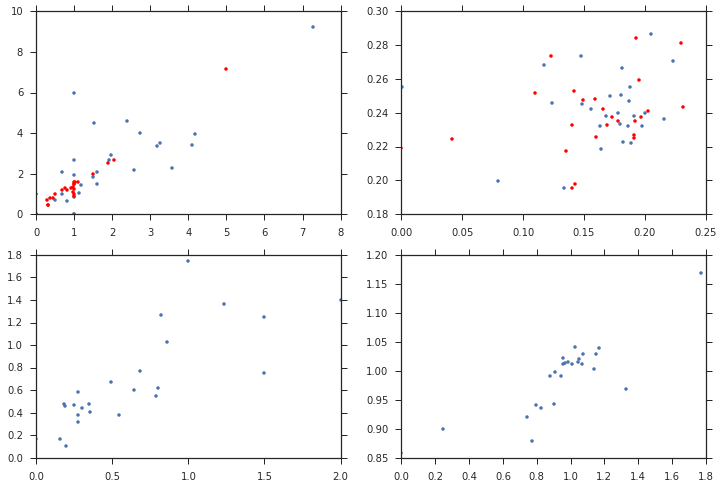

In [911]:
fig,ax=plt.subplots(2,2,figsize=[12,8])
ax[0][0].plot(comdf.bluedegree,comdf.SharedBlue,'.');
ax[0][0].plot(comdf.reddegree,comdf.SharedRed,'r.');
ax[0][1].plot(comdf.blueclose,comdf.blue_centrality,'.');
ax[0][1].plot(comdf.redclose,comdf.red_centrality,'r.');
ax[1][0].plot(comdf.reddegree/comdf.bluedegree,comdf.SharedRed/comdf.SharedBlue,'.')
ax[1][1].plot(comdf.redclose/comdf.blueclose,comdf.red_centrality/comdf.blue_centrality,'.')

(-0.53984273462386412, 0.0064724565017768316)

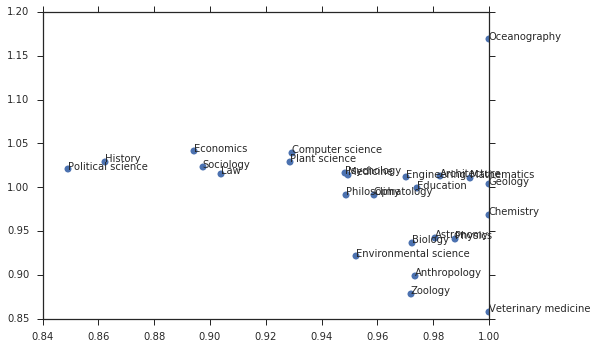

In [1922]:
plt.plot(comdf.bridgeness, comdf.red_centrality/comdf.blue_centrality,'o')
for i in xrange(len(comdf)):
    if not np.isnan(comdf.CentralityRatio[i]):
        plt.text(comdf.bridgeness[i],comdf.CentralityRatio[i],comdf.topic[i])
#plt.ylim([0.85,1.05])
y=comdf.red_centrality/comdf.blue_centrality
x=comdf.bridgeness[~np.isnan(y)]
y=y[~np.isnan(y)]
x=x[y<max(y)]
y=y[y<max(y)]
stats.pearsonr(x,y)

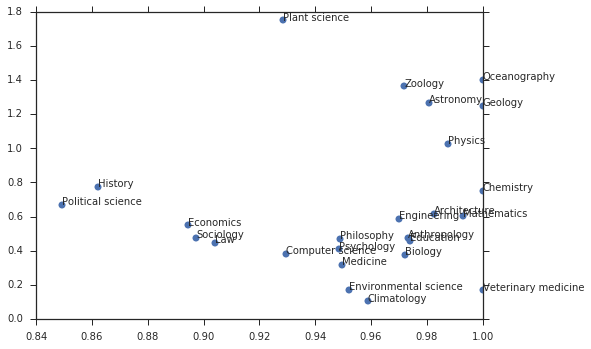

In [1924]:
plt.plot(comdf.bridgeness, comdf.SharedRed/comdf.SharedBlue,'o')
for i in xrange(len(comdf)):
    if not np.isnan(comdf.SharedRatio[i]):
        plt.text(comdf.bridgeness[i],comdf.SharedRatio[i],comdf.topic[i])
#plt.ylim([0.85,1.05])
#stats.pearsonr(comdf.bridgeness,y)

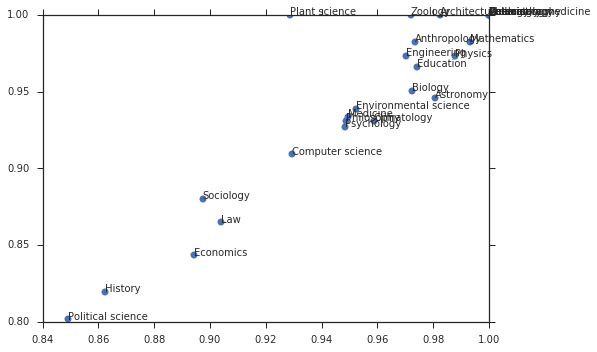

In [1654]:
plt.plot(comdf.bridgeness,comdf.polarization,'o')
for i in xrange(len(comdf)):
    plt.text(comdf.bridgeness[i],comdf.polarization[i],comdf.topic[i])

#### Political breadth

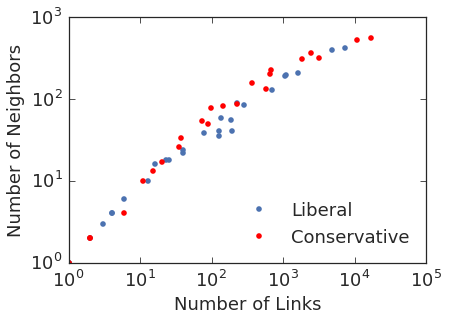

In [223]:
nodes=science.vs(depth=2)
plt.loglog(nodes['kb'],nodes['blueneighbors'],'o')
plt.loglog(nodes['kr'],nodes['redneighbors'],'ro')
plt.xlabel('Number of Links', fontsize=18)
plt.ylabel('Number of Neighbors', fontsize=18)
plt.legend(['Liberal', 'Conservative'],loc='best', fontsize=18);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.minorticks_off()

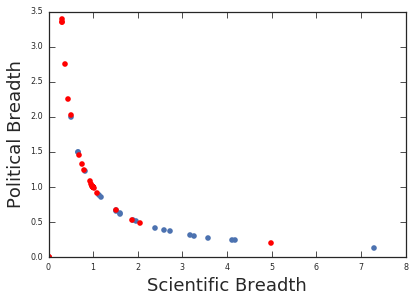

In [240]:
nodes=science.vs(depth=2)
plt.plot(nodes['bluebreadth'], nodes['bluepbreadth'],'o')
plt.plot(nodes['redbreadth'], nodes['redpbreadth'],'ro')
# for x,y,l in zip(np.array(nodes['redcentrality'])*1.0/np.array(nodes['bluecentrality']),np.array(nodes['redneighbors'])*1.0/np.array(nodes['blueneighbors']),nodes['label']):
#     plt.text(x,y,l)
plt.xlabel('Scientific Breadth', fontsize=18)
plt.ylabel('Political Breadth', fontsize=18);

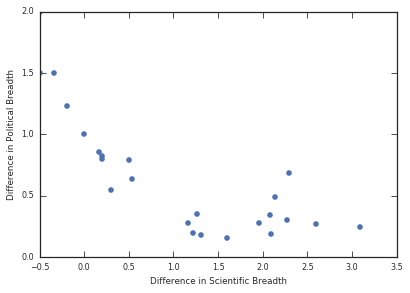

In [235]:
nodes=science.vs(depth=2)
plt.plot(np.array(nodes['bluebreadth'])-np.array(nodes['redbreadth']),np.array(nodes['bluepbreadth'])*1.0/(np.array(nodes['redpbreadth'])),'o')
# for x,y,l in zip(np.array(nodes['redcentrality'])*1.0/np.array(nodes['bluecentrality']),np.array(nodes['redneighbors'])*1.0/np.array(nodes['blueneighbors']),nodes['label']):
#     plt.text(x,y,l)
plt.xlabel('Difference in Scientific Breadth')
plt.ylabel('Difference in Political Breadth');

#### Save all results to text

In [247]:
nodes=D_dd.vs(depth=3)
df=pd.DataFrame({'label': nodes['label'],
                 'alignment': zip(*nodes['color'])[0],
                 'lowa': zip(*nodes['ci'])[0],
                 'upa': zip(*nodes['ci'])[1],
                 #'polarization': nodes['polarization'],
                 #'redclose': nodes['redclose'],
                 #'blueclose': nodes['blueclose'], 
                 #'redbreadth': nodes['redbreadth'],
                 #'bluebreadth': nodes['bluebreadth'],
                 'pbooks': nodes['psize'],
                 'topic': nodes['name'],
                 "patentCites": nodes['patentCites'],
                 "journalCites": nodes['journalCites']})

In [248]:
df.to_csv('../Disciplines/subdisciplines_top_classification.tsv',sep='\t', index=False)

#### Network of copurchases

In [ ]:
copurchases={}
copurchases[D_com.vs[0]['name'],N_com.vs[0]['name']]=len(g.es(_between=(list(D_com.vs[0]['books']),list(N_com.vs[0]['books']))))
for i in N_com.vs(depth=1):
    for j in N_com.vs(depth=1):
        if i.index<j.index:
             copurchases[i['name'],j['name']]=len(g.es(_between=(list(i['books']),list(j['books']))))
for i in D_com.vs(depth=1):
    for j in D_com.vs(depth=1):
        if i.index<j.index:
             copurchases[i['name'],j['name']]=len(g.es(_between=(list(i['books']),list(j['books']))))
for i in N_com.vs(depth=1):
    for j in D_com.vs(depth=1):
        copurchases[i['name'],j['name']]=len(g.es(_between=(list(i['books']),list(j['books']))))

In [198]:
G=Graph(directed=False)
for u in D_com.vs(depth_le=1):
    G.add_vertex(u['name'])
    G.vs.find(u['name'])['size']=u['size']
    G.vs.find(u['name'])['label']=u['label']
    G.vs.find(u['name'])['relevance']=u['relevance']
    G.vs.find(u['name'])['polarization']=u['polarization']
    G.vs.find(u['name'])['alignment']=u['color'][0]
    G.vs.find(u['name'])['science']=1
for u in N_com.vs(depth_le=1):
    G.add_vertex(u['name'])
    G.vs.find(u['name'])['size']=u['size']
    G.vs.find(u['name'])['label']=u['label']
    G.vs.find(u['name'])['relevance']=u['relevance']
    G.vs.find(u['name'])['polarization']=u['polarization']
    G.vs.find(u['name'])['alignment']=u['color'][0]
    G.vs.find(u['name'])['science']=0
for key in copurchases:
    G.add_edge(key[0],key[1],weight=copurchases[key])

In [199]:
G.vs['relevance']=(G.vs['relevance']-np.mean(G.vs['relevance']))/np.std(G.vs['relevance'])*500
G.vs['polarization']=(G.vs['polarization']-np.mean(G.vs['polarization']))/np.std(G.vs['polarization'])*500
G.vs['alignment']=(G.vs['alignment']-np.mean(G.vs['alignment']))/np.std(G.vs['alignment'])*500
G.write_gml('../Disciplines/sciencevsNonscience.gml')